In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, DivergingNorm
import matplotlib.colors as colors
plt.rcParams['figure.max_open_warning'] = 500
import qcodes as qc
import qcodes.instrument_drivers.nplab_drivers as npd
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d, interp1d
from os import path
import colorcet as cc   # install quickly with "conda install colorcet"
from scipy.interpolate import RectBivariateSpline
from matplotlib import ticker
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from lmfit import Model
import glob
from scipy.special import digamma
import emcee

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.markersize'] = 4
%config InlineBackend.figure_format = 'svg'

font = {
                'family': 'Arial',
                'size': 12,
                'serif': 'Times',
                'sans-serif': 'Arial'
            }

plt.rc('font', **font)

In [3]:
cd ..

/Users/robertpolski/Documents/NPGroupResearch/Measurements/Triton/qcodes_data


In [4]:
qc.DataSet.default_io.base_location = path.abspath('.')

In [5]:
figfile = 'Figures/W5_WALpeaks/'

In [6]:
esqh = 1.602e-19**2/6.626e-34

# -2 V (backgate)

First, here is the filling factor and density of electrons

In [7]:
V0 = 0.34
Vgatefull = 5.1
nu = np.interp(-2, [V0 - 7/4*Vgatefull, V0 + 7/4*Vgatefull], [-7, 7])  # the filling of -6 Vg
print(f'Filling factor: {nu}')
nfull = 1.504322970117718
print(f'Electron density: {nu*nfull/4} e12 cm^-2')  # the density of electrons, relative to CNP in 10^12 /cm^2

Filling factor: -1.8352941176470585
Electron density: -0.6902187745245999 e12 cm^-2


In [8]:
barr = np.linspace(-0.025, 0.025, 251)  # same field array for most of these

## Base Temperature

In [9]:
garr2_base = np.linspace(-1.74, -2.34, 31)
garr2_base

array([-1.74, -1.76, -1.78, -1.8 , -1.82, -1.84, -1.86, -1.88, -1.9 ,
       -1.92, -1.94, -1.96, -1.98, -2.  , -2.02, -2.04, -2.06, -2.08,
       -2.1 , -2.12, -2.14, -2.16, -2.18, -2.2 , -2.22, -2.24, -2.26,
       -2.28, -2.3 , -2.32, -2.34])

In [10]:
Vn2_865_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_baseT_40-39.txt')
Vn2_830_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_baseT_39-38.txt')

In [11]:
# Note that pt 11 (-1.96V) in this array was messed up, so we remove it here
rmvind = [i != 11 for i in range(len(garr2_base))]
Vn2_865_base = Vn2_865_base[rmvind, :]
Vn2_830_base = Vn2_830_base[rmvind, :]
garr2_base = garr2_base[rmvind]

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

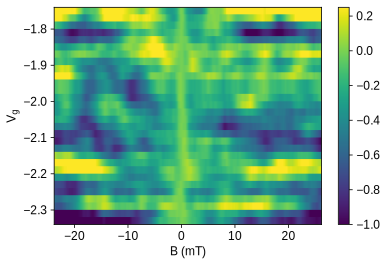

In [12]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_base = np.zeros(Vn2_865_base.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_base[i, :] = 1/(Vn2_865_base[i, :]/curr)/esqh - 1/(Vn2_865_base[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_base, gaussian_filter(dGn2_865_base, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

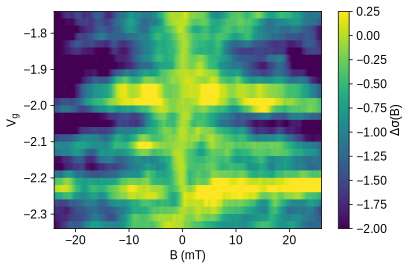

In [13]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn2_830_base = np.zeros(Vn2_865_base.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_base[i, :] = 1/(Vn2_830_base[i, :]/curr)/esqh - 1/(Vn2_830_base[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_base, gaussian_filter(dGn2_830_base, (0.8,0.8)), vmin=-2, vmax=0.25, rasterized=True) #vmin=-2, vmax=0.25,
plt.colorbar(label='$\Delta\sigma$(B)')
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


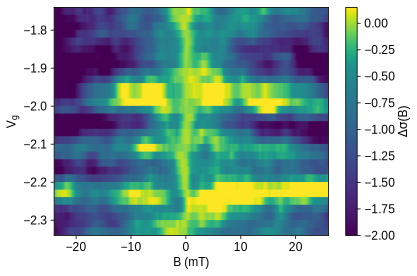

In [14]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn2_830_base = np.zeros(Vn2_865_base.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_base[i, :] = 1/(Vn2_830_base[i, :]/curr)/esqh - 1/(Vn2_830_base[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_base, gaussian_filter(dGn2_830_base, (0.8,0.8)), cmap='viridis', norm=DivergingNorm(vmin=-2, vmax=.15, vcenter=-0.4), rasterized=True) #vmin=-2, vmax=0.25,
plt.colorbar(label='$\Delta\sigma$(B)')
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')
plt.tight_layout()
# plt.savefig(figfile + 'W5_3938_WAL2dbase_-2Vbg.svg', bbox_inches='tight', dpi=300)

## 300 mK

In [15]:
Vn2_865_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_300mK_40-39.txt')
Vn2_830_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_300mK_39-38.txt')

In [16]:
garr2_300 = np.linspace(-1.74, -2.32, 30)
garr2_300

array([-1.74, -1.76, -1.78, -1.8 , -1.82, -1.84, -1.86, -1.88, -1.9 ,
       -1.92, -1.94, -1.96, -1.98, -2.  , -2.02, -2.04, -2.06, -2.08,
       -2.1 , -2.12, -2.14, -2.16, -2.18, -2.2 , -2.22, -2.24, -2.26,
       -2.28, -2.3 , -2.32])

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

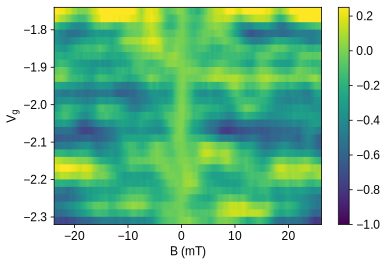

In [17]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_300 = np.zeros(Vn2_865_300.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_300[i, :] = 1/(Vn2_865_300[i, :]/curr)/esqh - 1/(Vn2_865_300[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_300, gaussian_filter(dGn2_865_300, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

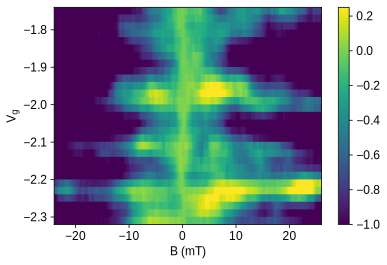

In [18]:
b0 = -1.0 # use this as the 0-field point (in mT)
dGn2_830_300 = np.zeros(Vn2_830_300.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_300[i, :] = 1/(Vn2_830_300[i, :]/curr)/esqh - 1/(Vn2_830_300[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_300, gaussian_filter(dGn2_830_300, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 500 mK

In [19]:
Vn2_865_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_500mK_40-39.txt')
Vn2_830_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_500mK_39-38.txt')

In [20]:
garr2_500 = np.linspace(-1.74, -2.32, 30)  # same as 300 mK

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

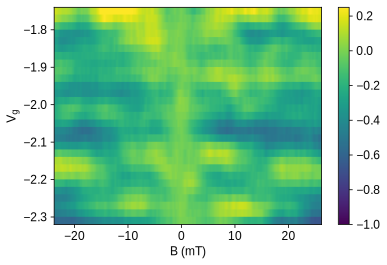

In [21]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_500 = np.zeros(Vn2_865_500.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_500[i, :] = 1/(Vn2_865_500[i, :]/curr)/esqh - 1/(Vn2_865_500[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_500, gaussian_filter(dGn2_865_500, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

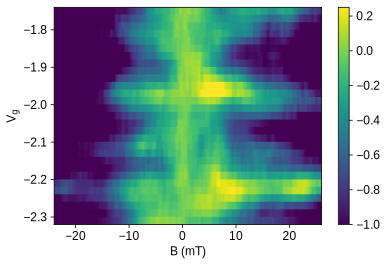

In [22]:
b0 = -1.0 # use this as the 0-field point (in mT)
dGn2_830_500 = np.zeros(Vn2_830_500.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_500[i, :] = 1/(Vn2_830_500[i, :]/curr)/esqh - 1/(Vn2_830_500[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_500, gaussian_filter(dGn2_830_500, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 700 mK

In [23]:
Vn2_865_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_700mK_40-39.txt')
Vn2_830_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_700mK_39-38.txt')

In [24]:
garr2_700 = np.linspace(-1.74, -2.32, 30)  # same as the previous two

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

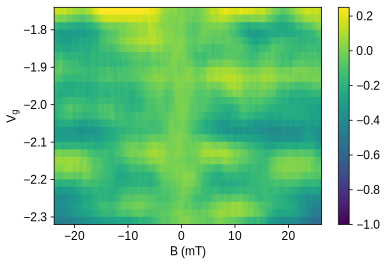

In [25]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_700 = np.zeros(Vn2_865_700.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_700[i, :] = 1/(Vn2_865_700[i, :]/curr)/esqh - 1/(Vn2_865_700[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_700, gaussian_filter(dGn2_865_700, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

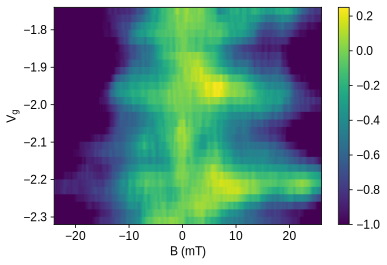

In [26]:
b0 = -1.0 # use this as the 0-field point (in mT)
dGn2_830_700 = np.zeros(Vn2_830_700.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_700[i, :] = 1/(Vn2_830_700[i, :]/curr)/esqh - 1/(Vn2_830_700[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_700, gaussian_filter(dGn2_830_700, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 900 mK

In [27]:
Vn2_865_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_900mK_40-39.txt')
Vn2_830_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_900mK_39-38.txt')

In [28]:
garr2_900 = np.linspace(-1.74, -2.32, 30)  # same as the previous two

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

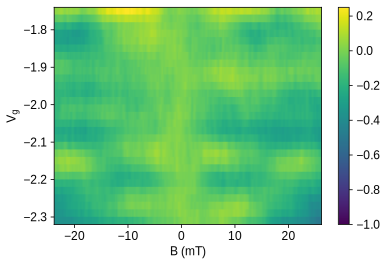

In [29]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_900 = np.zeros(Vn2_865_900.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_900[i, :] = 1/(Vn2_865_900[i, :]/curr)/esqh - 1/(Vn2_865_900[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_900, gaussian_filter(dGn2_865_900, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

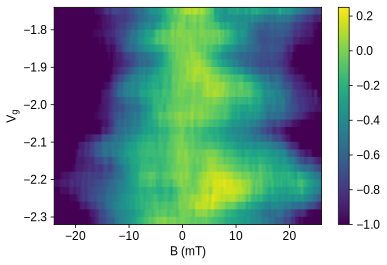

In [30]:
b0 = -1.0 # use this as the 0-field point (in mT)
dGn2_830_900 = np.zeros(Vn2_830_900.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_900[i, :] = 1/(Vn2_830_900[i, :]/curr)/esqh - 1/(Vn2_830_900[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_900, gaussian_filter(dGn2_830_900, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 3K

In [31]:
Vn2_865_3k = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_3K_40-39.txt')
Vn2_830_3k = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-2Vbg_3K_39-38.txt')

In [32]:
garr2_3k = np.linspace(-1.74, -2.32, 30)  # same as the previous two

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

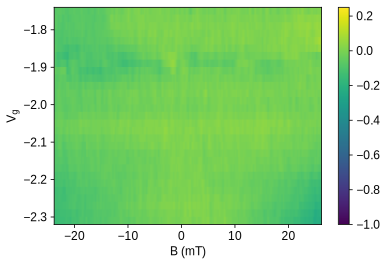

In [33]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn2_865_3k = np.zeros(Vn2_865_3k.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_865_3k.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_865_3k[i, :] = 1/(Vn2_865_3k[i, :]/curr)/esqh - 1/(Vn2_865_3k[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr2_3k, gaussian_filter(dGn2_865_3k, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

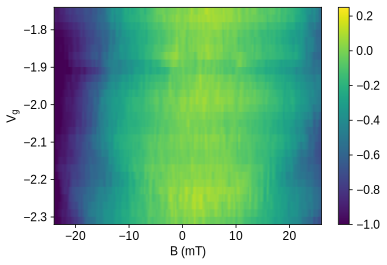

In [34]:
b0 = -1.0 # use this as the 0-field point (in mT)
dGn2_830_3k = np.zeros(Vn2_830_3k.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn2_830_3k.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_3k[i, :] = 1/(Vn2_830_3k[i, :]/curr)/esqh - 1/(Vn2_830_3k[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_3k, gaussian_filter(dGn2_830_3k, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## Overall averages  (The averages may look a little better if we select the ranges a bit)

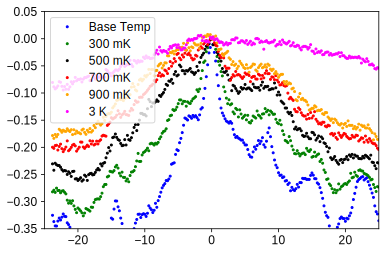

In [35]:
# Electrodes 40-39
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b1, np.average(dGn2_865_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b1, np.average(dGn2_865_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b1, np.average(dGn2_865_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b1, np.average(dGn2_865_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b1, np.average(dGn2_865_900, axis=0), '.', color='orange', label='900 mK')
plt.plot(barr*1000 - b1, np.average(dGn2_865_3k, axis=0), '.', color='magenta', label='3 K')
plt.axis((-25, 25, -0.35, 0.05))
# plt.axis((-1, 1, -0.05, 0.03))
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Subtract 3K')

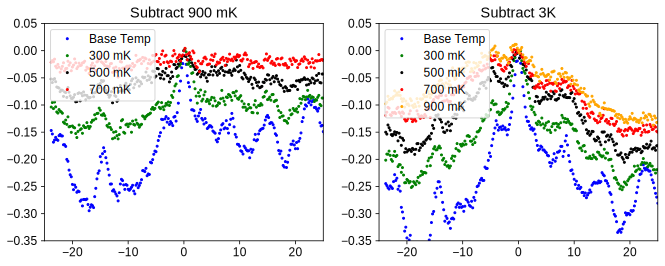

In [36]:
# Subtracting 900 mK data
# Electrodes 40-39
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(barr*1000 - b1, np.average(dGn2_865_base, axis=0) - np.average(dGn2_865_900, axis=0), '.b', label='Base Temp')
ax[0].plot(barr*1000 - b1, np.average(dGn2_865_300, axis=0) - np.average(dGn2_865_900, axis=0), '.g', label='300 mK')
ax[0].plot(barr*1000 - b1, np.average(dGn2_865_500, axis=0) - np.average(dGn2_865_900, axis=0), '.k', label='500 mK')
ax[0].plot(barr*1000 - b1, np.average(dGn2_865_700, axis=0) - np.average(dGn2_865_900, axis=0), '.r', label='700 mK')
# plt.plot(barr*1000 - b1, np.average(dGn2_865_900, axis=0), '.', color='orange', label='900 mK')
ax[0].axis((-25, 25, -0.35, 0.05))
ax[0].legend(loc='upper left')
ax[0].set_title('Subtract 900 mK')

#subtracting 3K data
ax[1].plot(barr*1000 - b1, np.average(dGn2_865_base, axis=0) - np.average(dGn2_865_3k, axis=0), '.b', label='Base Temp')
ax[1].plot(barr*1000 - b1, np.average(dGn2_865_300, axis=0) - np.average(dGn2_865_3k, axis=0), '.g', label='300 mK')
ax[1].plot(barr*1000 - b1, np.average(dGn2_865_500, axis=0) - np.average(dGn2_865_3k, axis=0), '.k', label='500 mK')
ax[1].plot(barr*1000 - b1, np.average(dGn2_865_700, axis=0) - np.average(dGn2_865_3k, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b1, np.average(dGn2_865_900, axis=0)  - np.average(dGn2_865_3k, axis=0), '.', color='orange', label='900 mK')
ax[1].axis((-25, 25, -0.35, 0.05))
ax[1].legend(loc='upper left')
ax[1].set_title('Subtract 3K')

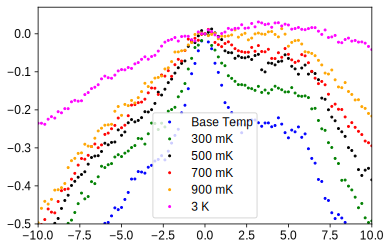

In [37]:
# Electrodes 39-38
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn2_830_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn2_830_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn2_830_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn2_830_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b0, np.average(dGn2_830_900, axis=0), '.', color='orange', label='900 mK')
plt.plot(barr*1000 - b0, np.average(dGn2_830_3k, axis=0), '.', color='magenta', label='3 K')
plt.axis((-10, 10, -0.5, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend()

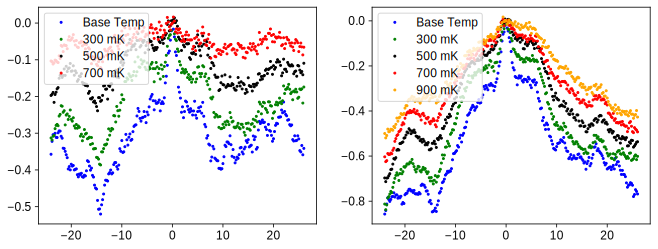

In [38]:
# Subtract 900 mK data
# Electrodes 39-38
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(barr*1000 - b0, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), '.b', label='Base Temp')
ax[0].plot(barr*1000 - b0, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), '.g', label='300 mK')
ax[0].plot(barr*1000 - b0, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), '.k', label='500 mK')
ax[0].plot(barr*1000 - b0, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), '.r', label='700 mK')
ax[0].legend(loc='upper left')

#subtract 3K data
ax[1].plot(barr*1000 - b0, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_3k, axis=0), '.b', label='Base Temp')
ax[1].plot(barr*1000 - b0, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_3k, axis=0), '.g', label='300 mK')
ax[1].plot(barr*1000 - b0, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_3k, axis=0), '.k', label='500 mK')
ax[1].plot(barr*1000 - b0, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_3k, axis=0), '.r', label='700 mK')
ax[1].plot(barr*1000 - b0, np.average(dGn2_830_900, axis=0) - np.average(dGn2_830_3k, axis=0), '.', color='orange', label='900 mK')
ax[1].legend(loc='upper left')

## Symmetrized peaks

In [39]:
def symmetrize(b, G, bpeak):
    """Enter the field values in b, conductance values in G, and the best estimate of the 
    field (in T) at the peak that should be at 0 field.
    
    This function assumes that bpeak is slightly less than 0 and, more importantly,
    that there are more field points above than below this point. It just concatenates points
    that can't be symmetrized.
    
    Returns a symmetrized b, G, G0 (or ignore G0 if you've already subtracted it)"""
    
    zptind = npd.val_to_index([bpeak], b)[0]
    G0 = G[zptind]
    Gpsym = 0.5*(G[:zptind+1][::-1] + G[zptind:zptind + zptind + 1])
    Gsymm = np.concatenate((Gpsym[::-1], Gpsym[1:]))

    bpsymm = (b[zptind:2*zptind + 1] - b[zptind])*1000
    bsymm = np.concatenate((-1*bpsymm[::-1], bpsymm[1:]))
    
    return bsymm, Gsymm, G0

-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead


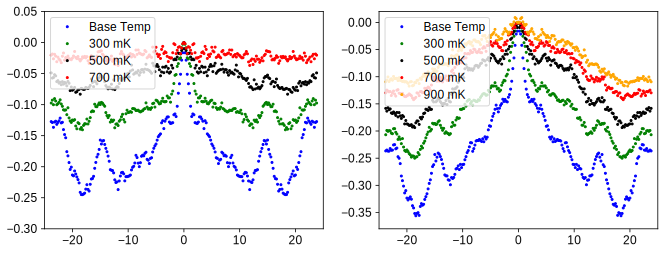

In [40]:
# Electrodes 40-39, using the data with 900 mK subtracted
b0 = -0.0012
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
bsymm865base, Gsymm865base, G0 = symmetrize(barr, np.average(dGn2_865_base, axis=0) - np.average(dGn2_865_900, axis=0), b0)
ax[0].plot(bsymm865base, Gsymm865base, '.b', label='Base Temp')
bsymm865300, Gsymm865300, G0 = symmetrize(barr, np.average(dGn2_865_300, axis=0) - np.average(dGn2_865_900, axis=0), b0)
ax[0].plot(bsymm865300, Gsymm865300, '.g', label='300 mK')
bsymm865500, Gsymm865500, G0 = symmetrize(barr, np.average(dGn2_865_500, axis=0) - np.average(dGn2_865_900, axis=0), b0)
ax[0].plot(bsymm865500, Gsymm865500, '.k', label='500 mK')
bsymm865700, Gsymm865700, G0 = symmetrize(barr, np.average(dGn2_865_700, axis=0) - np.average(dGn2_865_900, axis=0), b0)
ax[0].plot(bsymm865700, Gsymm865700, '.r', label='700 mK')
# bsymm865900, Gsymm865900, G0 = symmetrize(barr, np.average(dGn2_865_900, axis=0), -0.0012)
# plt.plot(bsymm865900, Gsymm865900, '.', color='orange', label='900 mK')
ax[0].axis((-25, 25, -0.3, 0.05))
ax[0].legend(loc='upper left')

# with 3K subtracted
bsymm865base3, Gsymm865base3, G0 = symmetrize(barr, np.average(dGn2_865_base, axis=0) - np.average(dGn2_865_3k, axis=0), b0)
ax[1].plot(bsymm865base3, Gsymm865base3, '.b', label='Base Temp')
bsymm8653003, Gsymm8653003, G0 = symmetrize(barr, np.average(dGn2_865_300, axis=0) - np.average(dGn2_865_3k, axis=0), b0)
ax[1].plot(bsymm8653003, Gsymm8653003, '.g', label='300 mK')
bsymm8655003, Gsymm8655003, G0 = symmetrize(barr, np.average(dGn2_865_500, axis=0) - np.average(dGn2_865_3k, axis=0), b0)
ax[1].plot(bsymm8655003, Gsymm8655003, '.k', label='500 mK')
bsymm8657003, Gsymm8657003, G0 = symmetrize(barr, np.average(dGn2_865_700, axis=0) - np.average(dGn2_865_3k, axis=0), b0)
ax[1].plot(bsymm8657003, Gsymm8657003, '.r', label='700 mK')
bsymm8659003, Gsymm8659003, G0 = symmetrize(barr, np.average(dGn2_865_900, axis=0) - np.average(dGn2_865_3k, axis=0), b0)
ax[1].plot(bsymm8659003, Gsymm8659003, '.', color='orange', label='900 mK')
ax[1].axis((-25, 25, -0.38, 0.02))
ax[1].legend(loc='upper left')

-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead


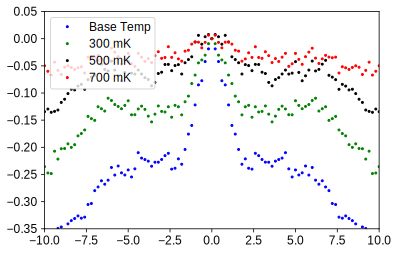

In [41]:
# Electrodes 39-38
plt.figure(figsize=(6, 4))
bsymm830base, Gsymm830base, G0 = symmetrize(barr, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(bsymm830base, Gsymm830base, '.b', label='Base Temp')
bsymm830300, Gsymm830300, G0 = symmetrize(barr, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(bsymm830300, Gsymm830300, '.g', label='300 mK')
bsymm830500, Gsymm830500, G0 = symmetrize(barr, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(bsymm830500, Gsymm830500, '.k', label='500 mK')
bsymm830700, Gsymm830700, G0 = symmetrize(barr, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(bsymm830700, Gsymm830700, '.r', label='700 mK')
# bsymm830900, Gsymm830900, G0 = symmetrize(barr, np.average(dGn2_830_900, axis=0), -0.001)
# plt.plot(bsymm830900, Gsymm830900, '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.35, 0.05))
plt.legend(loc='upper left')

# -3.5 V (backgate)

## Base temperature

In [42]:
barr = np.linspace(-0.025, 0.025, 251)  # same as for -2 V
garr_n35 = np.linspace(-3.26, -3.76, 26)

In [43]:
Vn35_865_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_baseT_40-39.txt')
Vn35_830_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_baseT_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

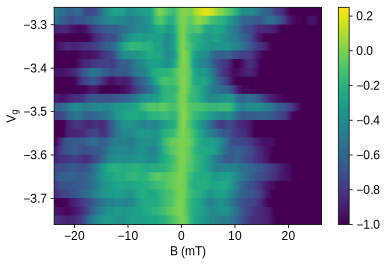

In [44]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn35_865_base = np.zeros(Vn35_865_base.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_865_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_865_base[i, :] = 1/(Vn35_865_base[i, :]/curr)/esqh - 1/(Vn35_865_base[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n35, gaussian_filter(dGn35_865_base, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

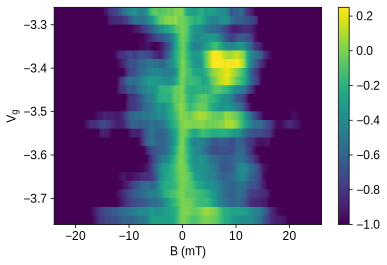

In [45]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn35_830_base = np.zeros(Vn35_830_base.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_830_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_830_base[i, :] = 1/(Vn35_830_base[i, :]/curr)/esqh - 1/(Vn35_830_base[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n35, gaussian_filter(dGn35_830_base, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 300 mK

In [46]:
Vn35_865_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_300mK_40-39.txt')
Vn35_830_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_300mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

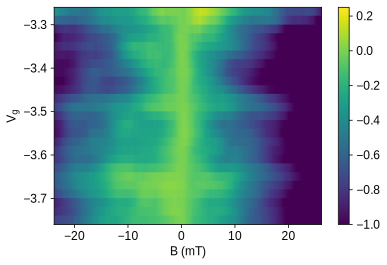

In [47]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn35_865_300 = np.zeros(Vn35_865_300.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_865_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_865_300[i, :] = 1/(Vn35_865_300[i, :]/curr)/esqh - 1/(Vn35_865_300[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n35, gaussian_filter(dGn35_865_300, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

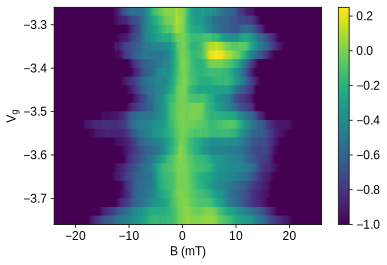

In [48]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn35_830_300 = np.zeros(Vn35_830_300.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_830_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_830_300[i, :] = 1/(Vn35_830_300[i, :]/curr)/esqh - 1/(Vn35_830_300[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n35, gaussian_filter(dGn35_830_300, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 500 mK

In [49]:
Vn35_865_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_500mK_40-39.txt')
Vn35_830_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_500mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

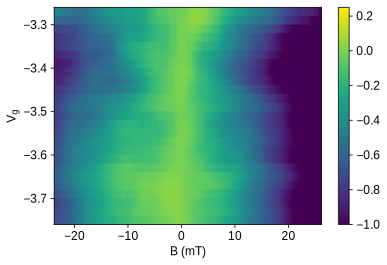

In [50]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn35_865_500 = np.zeros(Vn35_865_500.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_865_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_865_500[i, :] = 1/(Vn35_865_500[i, :]/curr)/esqh - 1/(Vn35_865_500[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n35, gaussian_filter(dGn35_865_500, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

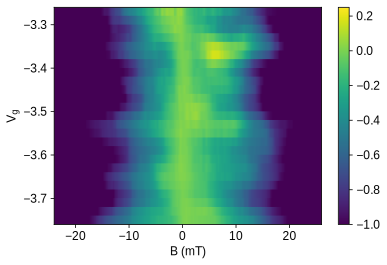

In [51]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn35_830_500 = np.zeros(Vn35_830_500.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_830_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_830_500[i, :] = 1/(Vn35_830_500[i, :]/curr)/esqh - 1/(Vn35_830_500[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n35, gaussian_filter(dGn35_830_500, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 700 mK

In [52]:
Vn35_865_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_700mK_40-39.txt')
Vn35_830_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_700mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

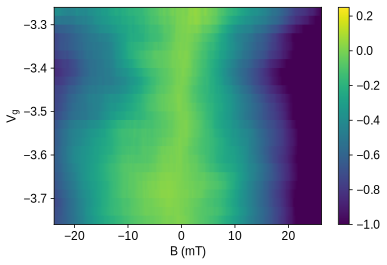

In [53]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn35_865_700 = np.zeros(Vn35_865_700.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_865_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_865_700[i, :] = 1/(Vn35_865_700[i, :]/curr)/esqh - 1/(Vn35_865_700[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n35, gaussian_filter(dGn35_865_700, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

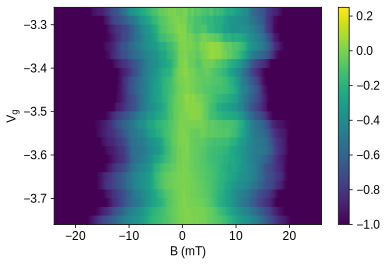

In [54]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn35_830_700 = np.zeros(Vn35_830_700.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_830_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_830_700[i, :] = 1/(Vn35_830_700[i, :]/curr)/esqh - 1/(Vn35_830_700[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n35, gaussian_filter(dGn35_830_700, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 900 mK

In [55]:
Vn35_865_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_900mK_40-39.txt')
Vn35_830_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-3p5Vbg_900mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

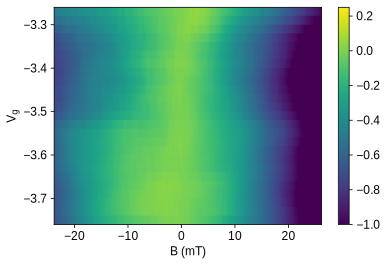

In [56]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn35_865_900 = np.zeros(Vn35_865_900.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_865_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_865_900[i, :] = 1/(Vn35_865_900[i, :]/curr)/esqh - 1/(Vn35_865_900[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n35, gaussian_filter(dGn35_865_900, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

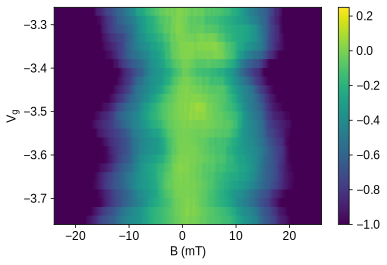

In [57]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn35_830_900 = np.zeros(Vn35_830_900.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn35_830_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn35_830_900[i, :] = 1/(Vn35_830_900[i, :]/curr)/esqh - 1/(Vn35_830_900[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n35, gaussian_filter(dGn35_830_900, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## Overall Averages

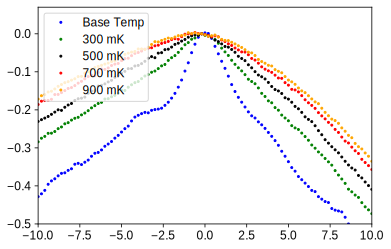

In [58]:
# Electrodes 40-39
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn35_865_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn35_865_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_865_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_865_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_865_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.5, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

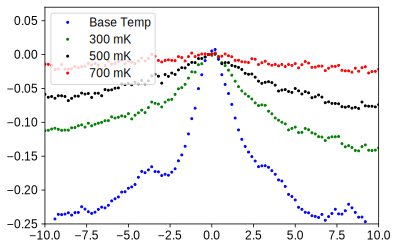

In [59]:
# Subtracting the highest temperature
# Electrodes 40-39
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn35_865_base, axis=0) - np.average(dGn35_865_900, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn35_865_300, axis=0) - np.average(dGn35_865_900, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_865_500, axis=0) - np.average(dGn35_865_900, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_865_700, axis=0) - np.average(dGn35_865_900, axis=0), '.r', label='700 mK')
# plt.plot(barr*1000 - b0, np.average(dGn35_865_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.25, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

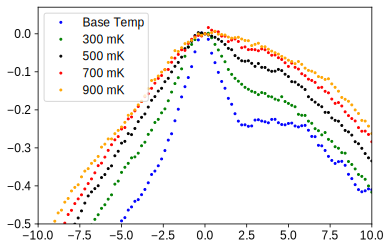

In [60]:
# Electrodes 39-38
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn35_830_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn35_830_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_830_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_830_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_830_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.5, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

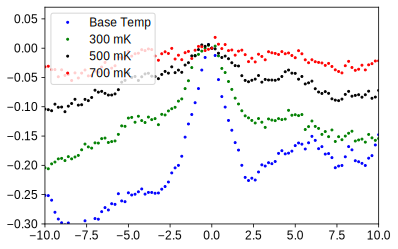

In [61]:
# subtracting the highest temperature
# Electrodes 39-38
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn35_830_base, axis=0) - np.average(dGn35_830_900, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn35_830_300, axis=0) - np.average(dGn35_830_900, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_830_500, axis=0) - np.average(dGn35_830_900, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn35_830_700, axis=0) - np.average(dGn35_830_900, axis=0), '.r', label='700 mK')
# plt.plot(barr*1000 - b0, np.average(dGn35_830_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.3, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

# -6 V (backgate)

In [62]:
V0 = 0.34
Vgatefull = 5.1
nu = np.interp(-6, [V0 - 7/4*Vgatefull, V0 + 7/4*Vgatefull], [-7, 7])  # the filling of -6 Vg
print(f'Filling factor: {nu}')
nfull = 1.504322970117718
print(f'Electron density: {nu*nfull/4} e12 cm^-2')  # the density of electrons, relative to CNP in 10^12 /cm^2
print(f'Electron density: {(nu + 4)*nfull/4} e12 cm^-2')  # the density of electrons, relative to full filling in 10^12 /cm^2

Filling factor: -4.972549019607843
Electron density: -1.8700799275581046 e12 cm^-2
Electron density: -0.3657569574403864 e12 cm^-2


## Base Temperature

In [63]:
garr_n6 = np.linspace(-5.74, -6.24, 26)

In [64]:
Vn6_865_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_baseT_40-39.txt')
Vn6_830_base = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_baseT_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

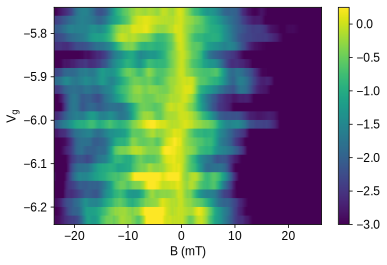

In [65]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn6_865_base = np.zeros(Vn6_865_base.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_865_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_865_base[i, :] = 1/(Vn6_865_base[i, :]/curr)/esqh - 1/(Vn6_865_base[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n6, gaussian_filter(dGn6_865_base, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


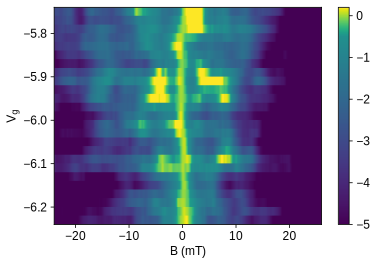

In [66]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn6_830_base = np.zeros(Vn6_830_base.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_830_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_830_base[i, :] = 1/(Vn6_830_base[i, :]/curr)/esqh - 1/(Vn6_830_base[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, gaussian_filter(dGn6_830_base, (0.8,0.8)), cmap='viridis', norm=DivergingNorm(vmin=-5, vmax=.2, vcenter=-0.5), rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')
plt.savefig(figfile + 'W5_3938_WAL2dbase_-6Vbg.svg', bbox_inches='tight', dpi=300)

## 300 mK

In [67]:
Vn6_865_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_300mK_40-39.txt')
Vn6_830_300 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_300mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

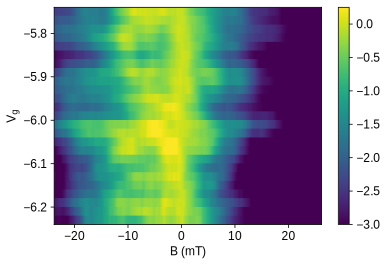

In [68]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn6_865_300 = np.zeros(Vn6_865_300.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_865_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_865_300[i, :] = 1/(Vn6_865_300[i, :]/curr)/esqh - 1/(Vn6_865_300[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n6, gaussian_filter(dGn6_865_300, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

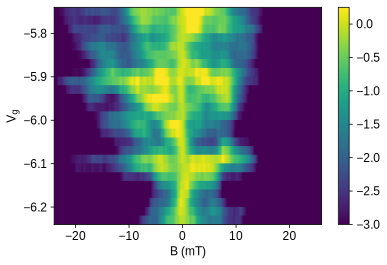

In [69]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn6_830_300 = np.zeros(Vn6_830_300.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_830_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_830_300[i, :] = 1/(Vn6_830_300[i, :]/curr)/esqh - 1/(Vn6_830_300[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, gaussian_filter(dGn6_830_300, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 500 mK

In [70]:
Vn6_865_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_500mK_40-39.txt')
Vn6_830_500 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_500mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

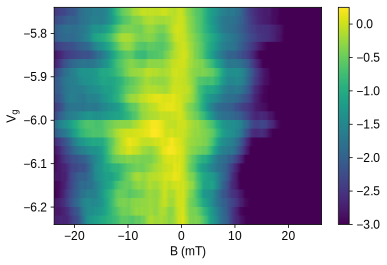

In [71]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn6_865_500 = np.zeros(Vn6_865_500.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_865_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_865_500[i, :] = 1/(Vn6_865_500[i, :]/curr)/esqh - 1/(Vn6_865_500[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n6, gaussian_filter(dGn6_865_500, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

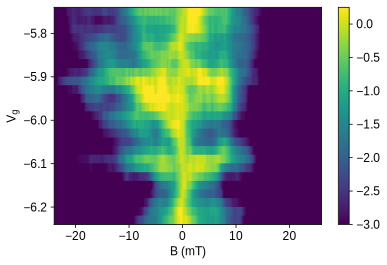

In [72]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn6_830_500 = np.zeros(Vn6_830_500.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_830_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_830_500[i, :] = 1/(Vn6_830_500[i, :]/curr)/esqh - 1/(Vn6_830_500[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, gaussian_filter(dGn6_830_500, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 700 mK

In [73]:
Vn6_865_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_700mK_40-39.txt')
Vn6_830_700 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_700mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

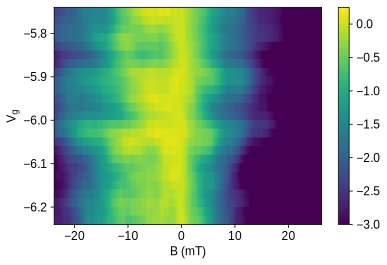

In [74]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn6_865_700 = np.zeros(Vn6_865_700.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_865_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_865_700[i, :] = 1/(Vn6_865_700[i, :]/curr)/esqh - 1/(Vn6_865_700[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n6, gaussian_filter(dGn6_865_700, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

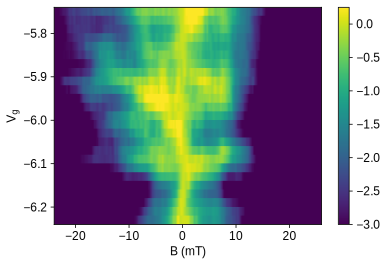

In [75]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn6_830_700 = np.zeros(Vn6_830_700.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_830_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_830_700[i, :] = 1/(Vn6_830_700[i, :]/curr)/esqh - 1/(Vn6_830_700[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, gaussian_filter(dGn6_830_700, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

## 900 mK

In [76]:
Vn6_865_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_900mK_40-39.txt')
Vn6_830_900 = np.loadtxt('AnalysisNotebooks/W5_WAL_arrays/W5_10nA_-6Vbg_900mK_39-38.txt')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

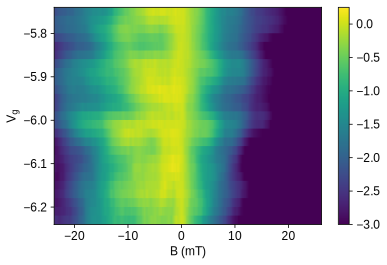

In [77]:
b1 = -1.2 # use this as the 0-field point (in mT)
dGn6_865_900 = np.zeros(Vn6_865_900.shape)
pind = npd.val_to_index([b1/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_865_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_865_900[i, :] = 1/(Vn6_865_900[i, :]/curr)/esqh - 1/(Vn6_865_900[i, pind]/curr)/esqh

plt.figure()  # lockin865 (40-39)
plt.pcolormesh(barr*1000 - b1, garr_n6, gaussian_filter(dGn6_865_900, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

-0.00 is not a value in the array
Plotted -0.00 instead


Text(0.5, 0, 'B (mT)')

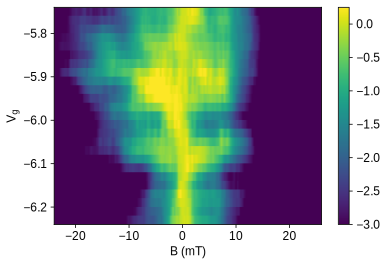

In [78]:
b0 = -1.0 # use this as the 0-field point (in mT) # for some reason this peak seems just slightly different in electrodes 39-38
dGn6_830_900 = np.zeros(Vn6_830_900.shape)
pind = npd.val_to_index([b0/1000], barr)[0] # find the index of the 0-field pt
curr = 10e-9
for i in range(Vn6_830_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn6_830_900[i, :] = 1/(Vn6_830_900[i, :]/curr)/esqh - 1/(Vn6_830_900[i, pind]/curr)/esqh

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, gaussian_filter(dGn6_830_900, (0.8,0.8)), vmin=-3, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

Text(0.5, 0, 'B (mT)')

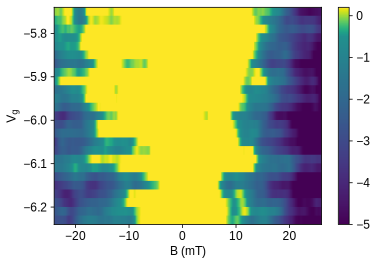

In [79]:
# subtract the 900 mK average from base temperature data for 39-38

subarrn6_base = np.subtract(gaussian_filter(dGn6_830_base, (0.8,1.1)), np.average(dGn6_830_900, ))

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr_n6, subarrn6_base, cmap='viridis', norm=DivergingNorm(vmin=-5, vmax=.2, vcenter=-0.5), rasterized=True)
plt.colorbar()
plt.ylabel('V$_{g}$')
plt.xlabel('B (mT)')

In [80]:
garr_n6

array([-5.74, -5.76, -5.78, -5.8 , -5.82, -5.84, -5.86, -5.88, -5.9 ,
       -5.92, -5.94, -5.96, -5.98, -6.  , -6.02, -6.04, -6.06, -6.08,
       -6.1 , -6.12, -6.14, -6.16, -6.18, -6.2 , -6.22, -6.24])

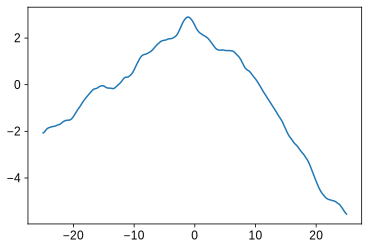

In [81]:
plt.figure()
plt.plot(barr*1000, np.average(subarrn6_base[0:], axis=0))

## Overall averages

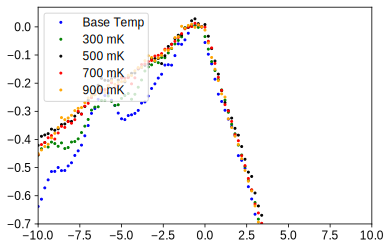

In [82]:
# Electrodes 40-39
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn6_865_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn6_865_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_865_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_865_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_865_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.7, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

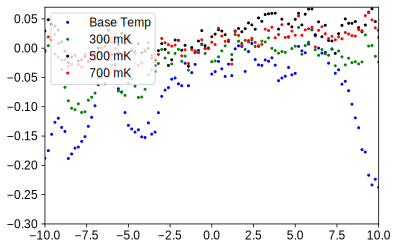

In [83]:
# subtract the highest temperature
# Electrodes 40-39
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn6_865_base, axis=0) - np.average(dGn6_865_900, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn6_865_300, axis=0) - np.average(dGn6_865_900, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_865_500, axis=0) - np.average(dGn6_865_900, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_865_700, axis=0) - np.average(dGn6_865_900, axis=0), '.r', label='700 mK')
# plt.plot(barr*1000 - b0, np.average(dGn6_865_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.3, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

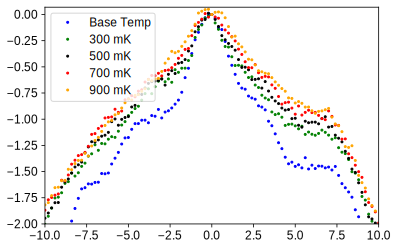

In [84]:
# Electrodes 39-38
plt.figure(figsize=(6, 4))
plt.plot(barr*1000 - b0, np.average(dGn6_830_base, axis=0), '.b', label='Base Temp')
plt.plot(barr*1000 - b0, np.average(dGn6_830_300, axis=0), '.g', label='300 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_830_500, axis=0), '.k', label='500 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_830_700, axis=0), '.r', label='700 mK')
plt.plot(barr*1000 - b0, np.average(dGn6_830_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -2, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

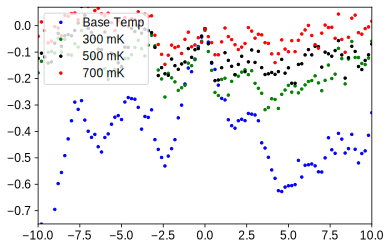

In [85]:
# subtract the highest temperature
# Electrodes 39-38
plt.figure(figsize=(6, 4))
MS = 5
plt.plot(barr*1000 - b0, gaussian_filter(np.average(dGn6_830_base, axis=0) - np.average(dGn6_830_900, axis=0), .5), '.b', label='Base Temp', ms=MS)
plt.plot(barr*1000 - b0, gaussian_filter(np.average(dGn6_830_300, axis=0) - np.average(dGn6_830_900, axis=0), .5), '.g', label='300 mK', ms=MS)
plt.plot(barr*1000 - b0, gaussian_filter(np.average(dGn6_830_500, axis=0) - np.average(dGn6_830_900, axis=0), .5), '.k', label='500 mK', ms=MS)
plt.plot(barr*1000 - b0, gaussian_filter(np.average(dGn6_830_700, axis=0) - np.average(dGn6_830_900, axis=0), .5), '.r', label='700 mK', ms=MS)
# plt.plot(barr*1000 - b0, np.average(dGn6_830_900, axis=0), '.', color='orange', label='900 mK')
plt.axis((-10, 10, -0.75, 0.07))
# plt.axis((-1, 1, -0.1, 0.03))
plt.legend(loc='upper left')

-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead


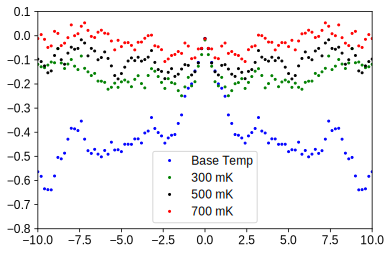

In [86]:
plt.figure(figsize=(6, 4))
bsymm830base6, Gsymm830base6, G0 = symmetrize(barr, gaussian_filter(np.average(dGn6_830_base, axis=0) - np.average(dGn6_830_900, axis=0), 0.5), -0.001)
plt.plot(bsymm830base6, Gsymm830base6, '.b', label='Base Temp')
bsymm8303006, Gsymm8303006, G0 = symmetrize(barr, gaussian_filter(np.average(dGn6_830_300, axis=0) - np.average(dGn6_830_900, axis=0), 0.5), -0.001)
plt.plot(bsymm8303006, Gsymm8303006, '.g', label='300 mK')
bsymm8305006, Gsymm8305006, G0 = symmetrize(barr, gaussian_filter(np.average(dGn6_830_500, axis=0) - np.average(dGn6_830_900, axis=0), 0.5), -0.001)
plt.plot(bsymm8305006, Gsymm8305006, '.k', label='500 mK')
bsymm8307006, Gsymm8307006, G0 = symmetrize(barr, gaussian_filter(np.average(dGn6_830_700, axis=0) - np.average(dGn6_830_900, axis=0), 0.5), -0.001)
plt.plot(bsymm8307006, Gsymm8307006, '.r', label='700 mK')
plt.axis((-10, 10, -0.8, 0.1))
plt.legend()

# Model fitting

**Some comments based on the literature:**

F. Tikhonenko, et al., PRL 2009 gives a good overview of the status for graphene right before people started using hBN (so more disorder from SiO2 but perhaps very similar). They mention a theory paper (E. Mccann, et al., PRL 2006) that suggests graphene should support WAL because of the chiral nature of the dirac electrons. However, weak localization returns due to intervalley scattering and atomically sharp scatterers such as edges and impurities. In SiO2, weak localization was largely the observation. However, WAL was observed by Tikhonenko by increasing the temperature and lowering the carrier density (just near the dirac point). In our case, the WAL gets stronger as we go lower in temperature, so we can rule this explanation out.

For good papers on the strong spin-orbit coupling (from TMDs) version of WAL theory, look at Morpurgo 2016 PRX and Zihlmann/Makk 2018 PRB (more info on the details and extra things you can pull out of the data since they have a good theorist on their team). The original theory is from McCann/Fal'Ko PRL 2012.

Other notes: The parameters of the model are D, the diffusion coefficient (for ML graphene, this comes from $v_F^2 \tau /2$, where the elastic scattering time $\tau$ is calculated from mobility, and $v_F$ is the graphene fermi velocity $\sim 10^6$ m/s in ML graphene); $\tau_{\phi}$, the dephasing (inelastic scattering) time; and two elastic scattering times: $\tau_{asy}$, which seems to be related to either intervalley scattering or scattering that results from breaking z $\rightarrow$ -z symmetry and $\tau_{so}$, which combines asymmetric and symmetric scattering ($\tau_{so}^{-1} = \tau_{asy}^-1 + \tau_{sym}^{-1}$, where the $\tau_{asy}$ and $\tau_{sym}$. The $\tau_{so}$ and $\tau_{asy}$ terms come from the Z. Wang paper in PRX 2016, as well as Morpurgo's previous papers, where they describe them as being the total SOC scattering and the asymmetric scattering due to breaking the plane symmetry

The equation:

\begin{equation}
\Delta \sigma(B) = -\frac{e^2}{2\pi h} \left[ F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1}}\right) - F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + 2\tau_{asy}^{-1}}\right) - 2F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + \tau_{so}^{-1}}\right) \right]
\end{equation}

where $F(x) = ln(x) + \psi(0.5 + x)$, $\psi$ is the digamma function, and $\tau_B^{-1} = 4eDB/\hbar$ (The factor of 1/2 out front is not there in the Morpurgo 2016 PRX paper, but it's likely a typo. This is the original expression and is in the McCann/Fal'Ko PRL 2012, 2015 Nat Comms Morpurgo, and 2016 Lau/Bockrath papers. It also is stated in Ihn's textbook that WAL should be about half the magnitude of WL, which is consistent here).

This equation looks very similar to that used in the Tikhonenko paper, where they were looking at a weak-localization-dominant picture, with different scattering times: $\tau_i$ is the inter-valley scattering time, which apparently can result from scatterers that also break time-reversal symmetry (according to the Morpurgo 2014 PRX paper on graphene/hBN, where they use the same equation), and $tau_*$, which is the intravalley scattering parameter. (For the equation above, it is suggested in the Zihlmann/Makk 2018 PRB paper that it is only relevant when the intervalley scattering is stronger than the phase coherence relaxation rate.)

\begin{equation}
\Delta \sigma(B) = \frac{e^2}{\pi h} \left[ F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1}}\right) - F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + 2\tau_i^{-1}}\right) - 2F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + \tau_i^{-1} + \tau_*^{-1}}\right) \right]
\end{equation}

The only difference in this equation is the positive sign out front and the factor of 1/2 is not present. It appears that whether it's weak localization or weak anti-localization, it's a very similar spin relaxation mechanism, but obviously the scattering times vary between being related to spin-orbit scattering and other forms of scattering. In our case, we use the equation with a negative sign out front. The second equation here describes the situation when there is not strong spin-orbit coupling (though it can describe weak forms of both WL and WAL, which are a bit complicated graphene when you consider different temperatures and proximity to dirac cones, as seen in the 2018 PRB Anindya Das paper)

For some intuition, the Tikhonenko paper gives us this (just remember that when their scattering parameters give them stronger WL, the scattering parameters in similar spots in our equation give us stronger WAL), : in the case of very low inter and intra-valley scattering ($\tau_*, \tau_i \rightarrow \infty$), the final term is the strongest. When the inter and intra-valley scattering is large, then the second and third terms get small, and the first term dominates, corresponding to localization. The reason Tikhonenko et al. were able to see WAL was because they raised the temp (decreasing $\tau_{\phi}$) and lowered the carrier density (increasing $\tau_i$), and the overall bonus of this was decreasing the ratios $\tau_{\phi}/\tau_i$ and $\tau_{\phi}/\tau_*$. This picture can be further intuited by realizing that, for low z, $F(z) \approx z^2/24$. (Note that for the SOC case, the signs flip on these intuitive pictures).

However, we're seeing WAL at the lowest temperatures, similar to papers where SOC is induced in ML graphene by proximity to TMDs.

The other parameters used for the fit are the diffusion constant ($D$) and the momentum scattering ($\tau$, or sometimes in papers $\tau_p$):

\begin{equation}
D = \frac{v_F^2 \tau}{2}
\end{equation}

This is taken to be T-independent, and in our case $v_F$ differs from ML graphene and is somewhere in the range of $10^5$, approximately 10 times lower (according to Alex's models, and this looks a little larger than what was in Das Sarma's paper for magic-angle devices, so it seems consistent). However, we must consider that the flat bands can perhaps have a varying fermi velocity depending on density, and that other models don't agree on the flatness of the bands.  
Using $v_F = \hbar k_F / m^* \rightarrow m^* = \hbar \sqrt{\pi |n|}/v_F$ and the standard Drude model, we can derive the momentum scattering time:

\begin{eqnarray}
\sigma = & \frac{ne^2\tau}{m^*} &\\
\mu = & \frac{\sigma}{ne} & = \frac{e\tau}{m^*} = \frac{e\tau v_F}{\hbar \sqrt{\pi |n|}}\\
\tau & = & \frac{\mu \hbar \sqrt{\pi |n|}}{v_F e} = \frac{\hbar \sigma}{v_F e^2} \sqrt{\frac{\pi}{|n|}}
\end{eqnarray}

Using $\mu = \sigma/ne$ allows for $\tau$ to vary over the range of density, which is used in some papers. One perhaps difficult point for us is that the lower $v_F$ in TBG leads to larger $\tau$, and the standard picture of WAL and WL suggests that several scattering events happen before the phase coherence time $\tau_\phi$ (though it can be similar to $\tau_{so}$, which perhaps depends on the mechanism of spin-orbit coupling).


## Trying to repeat plots that are in other papers

Finally repeated something!!! This is from the PRX Morpurgo paper in 2014. Just WL, but it's something to start from. They use $D = v_F^2 \tau/2$ and a derivation of $\tau$ from $\sigma$, likely somewhat similar to the standard drude result (though given that graphene electrons are "massless", what is the effective mass here? Maybe there's another expression) $\sigma = nq^2\tau/m \rightarrow \tau = \sigma m/(n q^2)$

In [49]:
def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

(-2.2, 2.2)

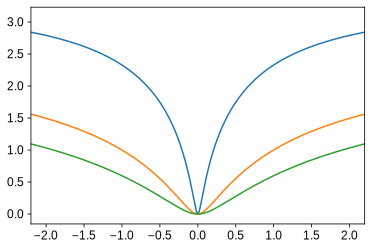

In [836]:
def dsigma_WL(B):
    D = 10**12*0.35e-12/2  # calculated from vf^2 tau/2 based on the 2014 PRX morpurgo paper
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
    tauphi = 50e-12
    tauiv = 6e-12
    taustar = 0.17e-12
#     return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))
    return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))

plt.figure()
bv = np.linspace(0.00001, 0.004, 801)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
y = np.concatenate((dsigma_WL(bv)[::-1], dsigma_WL(bv)[1:]))
plt.plot(bvs*1000, y*10**5)

def dsigma_WL(B):
    D = 10**12*0.17e-12/2  # calculated from vf^2 tau/2 based on the 2014 PRX morpurgo paper
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
    tauphi = 23e-12
    tauiv = 6e-12
    taustar = 0.14e-12
#     return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))
    return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))

y = np.concatenate((dsigma_WL(bv)[::-1], dsigma_WL(bv)[1:]))
plt.plot(bvs*1000, y*10**5)

def dsigma_WL(B):
    D = 10**12*0.12e-12/2  # calculated from vf^2 tau/2 based on the 2014 PRX morpurgo paper
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
    tauphi = 18e-12
    tauiv = 6e-12
    taustar = 0.2e-12
#     return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))
    return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))

y = np.concatenate((dsigma_WL(bv)[::-1], dsigma_WL(bv)[1:]))
plt.plot(bvs*1000, y*10**5)
plt.xlim(-2.2, 2.2)  # this scale is correct and fits the 3 points where they specify tau, tauphi, tauiv, and taustar.

In [837]:
s = 100*esqh
s*9.11e-31/(0.95e16*1.602e-19**2)

1.4472492731980871e-11

Now let's go back to the Morpurgo paper from Nat. Comms. 2015, ML graphene on WS2. They used give the estimated $\tau$ values

In [844]:
def dsigma_WAL(B, tau, tauphi, tauasy, tauso):  
    D = 10**12*tau/2  # calculated from vf^2 tau/2 based on the 2014 PRX morpurgo paper
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 50e-12
#     tauasy = 6e-12
#     tauso = 0.17e-12
#     return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))
    return -1.602e-19**2/(2*np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


In [840]:
print(10**12*0.2e-12/2)  # this is the value of D used, given tau = 0.2 ps

0.1


In [853]:
print(1.602e-19*0.2e-12/9.11e-31*10**4)  # the naive drude mobility, just to check if it is in the approximate range of 13,000 stated. Nope. There must be a different mobility-tau relation

351.701427003293


In [852]:
# Try a perhaps less naive approach, using Vf = hbar*kF/m, and kF = sqrt(pi n). Perfect!!
print(1.602e-19*0.2e-12*1e6/((6.626e-34/(2*np.pi))*np.sqrt(np.pi*1.7e16))*10**4)

13146.845136634765


Now I figured out how all the values are derived here. The main interesting ones are:

\begin{equation}
\tau = \frac{v_F^2 \tau}{2}
\end{equation}

(where $v_F \approx 10^6$, and this is taken to be T-independent)  
and (using $v_F = \hbar k_F / m^* \rightarrow m^* = \hbar \sqrt(\pi |n|)/v_F$ and the standard Drude model:

\begin{eqnarray}
\sigma = & \frac{ne^2\tau}{m^*} &\\
\mu = & \frac{\sigma}{ne} & = \frac{e\tau}{m^*} = \frac{e\tau v_F}{\hbar \sqrt{\pi |n|}}
\end{eqnarray}


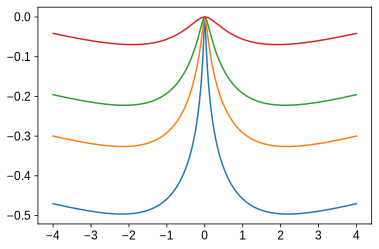

In [848]:
plt.figure()  # This worked pretty well for their plot Fig. 3d (region 3, for all four temperatures)
# I'm not sure why the negative sign and the factor of 1/2 appears suddenly for this analysis, as opposed to other analyses, but the fits work
tauasy = 5e-12
tauso = 2.8e-12
bv = np.linspace(0.00001, 0.004, 801)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
y0 = dsigma_WAL(bv, 0.2e-12, 260e-12, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

y0 = dsigma_WAL(bv, 0.2e-12, 85e-12, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

y0 = dsigma_WAL(bv, 0.2e-12, 41e-12, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

y0 = dsigma_WAL(bv, 0.2e-12, 11e-12, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

Now try to replicate the PRX 2016 Morpurgo paper

In [881]:
def dsigma_WAL(B, tau, tauphi, tauasy, tauso):  
    D = 10**12*tau/2  # calculated from vf^2 tau/2 based on the 2014 PRX morpurgo paper
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 50e-12
#     tauasy = 6e-12
#     tauso = 0.17e-12
#     return 1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauiv**-1)) - 2*F(taubinv/(tauphi**-1 + tauiv**-1 + taustar**-1)))
    return -1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


In [882]:
hbar = 6.626e-34/(2*np.pi)

In [883]:
# using mobility 3000 and reasonable density, the elastic scattering time should be around 0.04 ps (yes!)
3000/10**4*hbar*np.sqrt(np.pi*1e16)/(1.602e-19*10**6)

3.500299794557522e-14

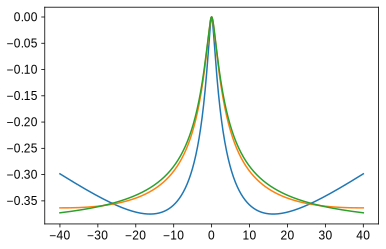

In [893]:
plt.figure()  # try to fit Fig 5 a, with tau = 0.04 ps
bv = np.linspace(0.00001, 0.040, 801)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
tauphi = 30e-12
tauasy = 15e-12
tauso = 0.78e-12
y0 = dsigma_WAL(bv, 0.04e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

tauphi = 21e-12
tauasy = 15e-12
tauso = 0.2e-12
y0 = dsigma_WAL(bv, 0.04e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

tauphi = 20e-12
tauasy = 15e-12
tauso = 0.04e-12
y0 = dsigma_WAL(bv, 0.04e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

In [896]:
# mobility 23400
23400/10**4*hbar*np.sqrt(np.pi*1e16)/(1.602e-19*10**6)

2.730233839754867e-13

(-30, 30)

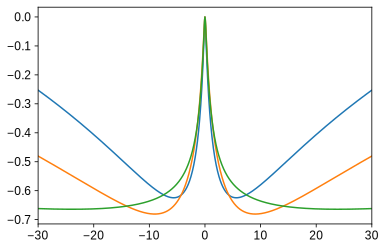

In [963]:
plt.figure()  # try to fit Fig 5 b, (since the mobility should be closer to ours) with tau ~ 0.3 ps. This works!
bv = np.linspace(0.00001, 0.040, 801)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
tauphi = 20e-12
tauasy = 1e-12
tauso = 0.8e-12
y0 = dsigma_WAL(bv, 0.3e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

tauphi = 15e-12
tauasy = 1e-12
tauso = 0.4e-12
y0 = dsigma_WAL(bv, 0.3e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)

tauphi = 17e-12
tauasy = 4e-12
tauso = 0.04e-12
y0 = dsigma_WAL(bv, 0.3e-12, tauphi, tauasy, tauso)
y = np.concatenate((y0[::-1], y0[1:]))
plt.plot(bvs*1000, y/esqh)
plt.xlim(-30, 30)

## Gate sweeps for these contacts (1 nA, base temp) and model fits

In [87]:
# both on lockin865
d4039 = qc.load_data('data/2020-02-03/#003_W5_basetemp_1nA_I41-35_V40-39_865_11-14-55')
d3938 = qc.load_data('data/2020-02-03/#002_W5_basetemp_1nA_I41-35_V39-38_865_11-05-14')
Rxx4039 = npd.Rxxfromdata(d4039, 1e-9, 'lockin865')
g4039 = d4039.srframe_volt_p1_set[:]
Rxx3938 = npd.Rxxfromdata(d3938, 1e-9, 'lockin865')
g3938 = d3938.srframe_volt_p1_set[:]

[200]
[280]


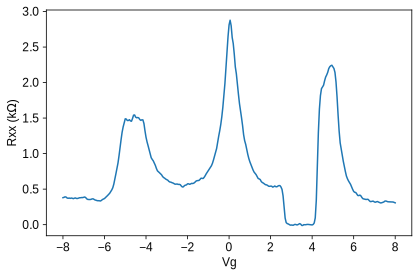

In [88]:
plt.figure()
plt.plot(g3938, gaussian_filter(Rxx3938, 0.9)/1000)
plt.xlabel('Vg')
plt.ylabel('Rxx (k$\Omega$)')
plt.tight_layout()
plt.savefig(figfile + 'W5_3938_gatesweep.svg', bbox_inches='tight')

print(npd.val_to_index([-2], g3938))
print(npd.val_to_index([-6], g3938))

In [89]:
sigman2 = 1/np.average(Rxx3938[198:203])
sigman2

0.0017671804947803048

In [90]:
# corresponds to a mobility (using the density of electrons wrt the CNP at this point)
mu = sigman2/(1.602e-19*0.6902187745245999e16)
mu*10**4

15982.018510632675

Try using $0.1v_{F, ML} \approx 10^5$ for the Fermi velocity, since the Wu, Hwang, Das Sarma PRB 2019 paper suggests that the fermi velocity of TBG right near the magic angle should be $~0.03v_{F, ML}$, and our smaller angles should result in a slightly larger Fermi velocity.

In [91]:
hbar = (6.626e-34/(2*np.pi))

In [92]:
# From this we can get a scattering time of approximately
tau = mu*hbar*np.sqrt(np.pi*0.6902187745245999e16)/(1.602e-19*1e5)
tau*10**12  # 1.5 ps

1.5492053969654063

In [93]:
# this corresponds with a diffusion constant
D = 1e5**2*tau/2
D

0.007746026984827032

In [94]:
def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

In [95]:
def dsigma_WAL(B, tauphi, tauasy, tauso):  
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 50e-12
#     tauasy = 6e-12
#     tauso = 0.17e-12

    return -1.602e-19**2/(2*np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead


Text(0, 0.5, '$\\Delta\\sigma$(B)')

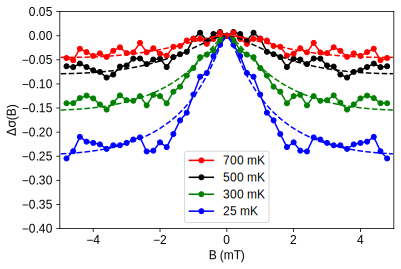

In [96]:
# Then just try manipulating tau_phi for the different temperatures, with tau_asy and tau_so the same for each curve
# Find the maximal tau_so that allows for the curves to fit fairly well without having a large upturn

xmin, xmax = -5, 5
ymin, ymax = -0.4, 0.05

Msize = 10
plt.figure(figsize=(6, 4))
bsymm830base, Gsymm830base, G0 = symmetrize(barr, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
l1 = plt.plot(np.ma.masked_outside(bsymm830base, xmin, xmax), Gsymm830base, '.-b', label='Base Temp', ms=Msize)
bsymm830300, Gsymm830300, G0 = symmetrize(barr, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
l2 = plt.plot(np.ma.masked_outside(bsymm830300, xmin, xmax), Gsymm830300, '.-g', label='300 mK', ms=Msize)
bsymm830500, Gsymm830500, G0 = symmetrize(barr, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
l3 = plt.plot(np.ma.masked_outside(bsymm830500, xmin, xmax), Gsymm830500, '.-k', label='500 mK', ms=Msize)
bsymm830700, Gsymm830700, G0 = symmetrize(barr, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
l4 = plt.plot(np.ma.masked_outside(bsymm830700, xmin, xmax), Gsymm830700, '.-r', label='700 mK', ms=Msize)


tauasy = 32e-12
tauso = 12e-12
bv = np.linspace(0.00001, 0.025, 701)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
dsbase = dsigma_WAL(bv, 240e-12, tauasy, tauso)
ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), ybase/esqh, 'b--')

ds300 = dsigma_WAL(bv, 120e-12, tauasy, tauso)
y300 = np.concatenate((ds300[::-1], ds300[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y300/esqh, 'g--')

ds500 = dsigma_WAL(bv, 60e-12, tauasy, tauso)
y500 = np.concatenate((ds500[::-1], ds500[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y500/esqh, 'k--')

ds700 = dsigma_WAL(bv, 40e-12, tauasy, tauso)
y700 = np.concatenate((ds700[::-1], ds700[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y700/esqh, 'r--')

# def dsigma(B):
#     D = 170   # not sure if these values are anywhere close to the right range. Just trying some initial values.
#     taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 6e-15
#     tauasy = 1e-15
#     tauso = 1e-15
#     return -1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# y = np.concatenate((dsigma(bv)[::-1], dsigma(bv)[1:]))
# plt.plot(bvs*1000, y/esqh, '--b')

plt.axis((xmin, xmax, ymin, ymax))
plt.legend([l4[0], l3[0], l2[0], l1[0]], ['700 mK', '500 mK', '300 mK', '25 mK'])
plt.xlabel('B (mT)')
plt.ylabel('$\Delta\sigma$(B)')
# plt.savefig(figfile + 'WALfitplot_Vbg-2_39-38_12ps_smallfield.svg',  bbox_inches='tight')

-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead


Text(0, 0.5, '$\\Delta\\sigma$(B)')

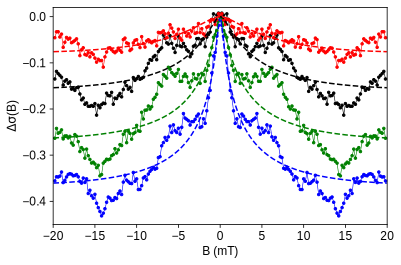

In [97]:
#V1
xmin, xmax = -20, 20
Msize = 5
LW = 0.6
plt.figure(figsize=(6, 4))
bsymm830base, Gsymm830base, G0 = symmetrize(barr, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830base, xmin, xmax), Gsymm830base, '.-b', label='Base Temp', ms=Msize, lw=LW)
bsymm830300, Gsymm830300, G0 = symmetrize(barr, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830300, xmin, xmax), Gsymm830300, '.-g', label='300 mK', ms=Msize, lw=LW)
bsymm830500, Gsymm830500, G0 = symmetrize(barr, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830500, xmin, xmax), Gsymm830500, '.-k', label='500 mK', ms=Msize, lw=LW)
bsymm830700, Gsymm830700, G0 = symmetrize(barr, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830700, xmin, xmax), Gsymm830700, '.-r', label='700 mK', ms=Msize, lw=LW)


tauasy = 40e-12
tausym = 1e-12
tauso = (tauasy**-1 + tausym**-1)**-1
bv = np.linspace(0.00001, 0.025, 701)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
dsbase = dsigma_WAL(bv, 240e-12, tauasy, tauso)
ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), ybase/esqh, 'b--')

ds300 = dsigma_WAL(bv, 120e-12, tauasy, tauso)
y300 = np.concatenate((ds300[::-1], ds300[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y300/esqh, 'g--')

ds500 = dsigma_WAL(bv, 50e-12, tauasy, tauso)
y500 = np.concatenate((ds500[::-1], ds500[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y500/esqh, 'k--')

ds700 = dsigma_WAL(bv, 22e-12, tauasy, tauso)
y700 = np.concatenate((ds700[::-1], ds700[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y700/esqh, 'r--')

# tauasy = 32e-12
# tauso = 12e-12
# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# dsbase = dsigma_WAL(bv, 240e-12, tauasy, tauso)
# ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
# plt.plot(bvs*1000, ybase/esqh, '--', color='magenta')

# ds300 = dsigma_WAL(bv, 120e-12, tauasy, tauso)
# y300 = np.concatenate((ds300[::-1], ds300[1:]))
# plt.plot(bvs*1000, y300/esqh, 'g--', color='magenta')

# ds500 = dsigma_WAL(bv, 60e-12, tauasy, tauso)
# y500 = np.concatenate((ds500[::-1], ds500[1:]))
# plt.plot(bvs*1000, y500/esqh, 'k--', color='magenta')

# ds700 = dsigma_WAL(bv, 40e-12, tauasy, tauso)
# y700 = np.concatenate((ds700[::-1], ds700[1:]))
# plt.plot(bvs*1000, y700/esqh, 'r--', color='magenta')

# def dsigma(B):
#     D = 170   # not sure if these values are anywhere close to the right range. Just trying some initial values.
#     taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 6e-15
#     tauasy = 1e-15
#     tauso = 1e-15
#     return -1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# y = np.concatenate((dsigma(bv)[::-1], dsigma(bv)[1:]))
# plt.plot(bvs*1000, y/esqh, '--b')

# plt.axis((-5, 5, -0.4, 0.05))
plt.axis((xmin, xmax, -0.45, 0.02))
# plt.legend(['700 mK', '500 mK', '300 mK', '25 mK'])
plt.xlabel('B (mT)')
plt.ylabel('$\Delta\sigma$(B)')
# plt.savefig(figfile + 'WALfitplot_Vbg-2_39-38_1ps_largefield_v2.svg', dpi=300, bbox_inches='tight')

In [98]:
#V2, try modifying D to get smaller SOI time scales

# From this we can get a scattering time of approximately
# vf = 1e5
# tau = mu*hbar*np.sqrt(np.pi*0.6902187745245999e16)/(1.602e-19*vf)

# this corresponds with a diffusion constant
D = 1e5**2*tau/2*3
# D
# tau*10**12  

In [99]:
def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

In [100]:
def dsigma_WAL(B, tauphi, tauasy, tauso):  
    taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 50e-12
#     tauasy = 6e-12
#     tauso = 0.17e-12

    return -1.602e-19**2/(2*np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
-0.00 is not a value in the array
Plotted -0.00 instead
tauso: 1e-12


Text(0, 0.5, '$\\Delta\\sigma$(B)')

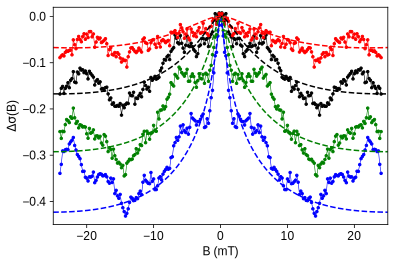

In [101]:
#V2
xmin, xmax = -25, 25
Msize = 5
LW = 0.6
plt.figure(figsize=(6, 4))
bsymm830base, Gsymm830base, G0 = symmetrize(barr, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830base, xmin, xmax), Gsymm830base, '.-b', label='Base Temp', ms=Msize, lw=LW)
bsymm830300, Gsymm830300, G0 = symmetrize(barr, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830300, xmin, xmax), Gsymm830300, '.-g', label='300 mK', ms=Msize, lw=LW)
bsymm830500, Gsymm830500, G0 = symmetrize(barr, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830500, xmin, xmax), Gsymm830500, '.-k', label='500 mK', ms=Msize, lw=LW)
bsymm830700, Gsymm830700, G0 = symmetrize(barr, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), -0.001)
plt.plot(np.ma.masked_outside(bsymm830700, xmin, xmax), Gsymm830700, '.-r', label='700 mK', ms=Msize, lw=LW)


tauasy = 2e-12
tausym = 2e-12
tauso = (tauasy**-1 + tausym**-1)**-1
print(f'tauso: {tauso}')
bv = np.linspace(0.00001, 0.025, 701)
bvs = np.concatenate((-1*bv[::-1], bv[1:]))
dsbase = dsigma_WAL(bv, 60e-12, tauasy, tauso)
ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), ybase/esqh, 'b--')

ds300 = dsigma_WAL(bv, 25e-12, tauasy, tauso)
y300 = np.concatenate((ds300[::-1], ds300[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y300/esqh, 'g--')

ds500 = dsigma_WAL(bv, 10e-12, tauasy, tauso)
y500 = np.concatenate((ds500[::-1], ds500[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y500/esqh, 'k--')

ds700 = dsigma_WAL(bv, 4e-12, tauasy, tauso)
y700 = np.concatenate((ds700[::-1], ds700[1:]))
plt.plot(np.ma.masked_outside(bvs*1000, xmin, xmax), y700/esqh, 'r--')

# tauasy = 32e-12
# tauso = 12e-12
# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# dsbase = dsigma_WAL(bv, 240e-12, tauasy, tauso)
# ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
# plt.plot(bvs*1000, ybase/esqh, '--', color='magenta')

# ds300 = dsigma_WAL(bv, 120e-12, tauasy, tauso)
# y300 = np.concatenate((ds300[::-1], ds300[1:]))
# plt.plot(bvs*1000, y300/esqh, 'g--', color='magenta')

# ds500 = dsigma_WAL(bv, 60e-12, tauasy, tauso)
# y500 = np.concatenate((ds500[::-1], ds500[1:]))
# plt.plot(bvs*1000, y500/esqh, 'k--', color='magenta')

# ds700 = dsigma_WAL(bv, 40e-12, tauasy, tauso)
# y700 = np.concatenate((ds700[::-1], ds700[1:]))
# plt.plot(bvs*1000, y700/esqh, 'r--', color='magenta')

# def dsigma(B):
#     D = 170   # not sure if these values are anywhere close to the right range. Just trying some initial values.
#     taubinv = 4*D*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 6e-15
#     tauasy = 1e-15
#     tauso = 1e-15
#     return -1.602e-19**2/(np.pi*6.626e-34)*(F(taubinv/tauphi**-1) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# y = np.concatenate((dsigma(bv)[::-1], dsigma(bv)[1:]))
# plt.plot(bvs*1000, y/esqh, '--b')

# plt.axis((-5, 5, -0.4, 0.05))
plt.axis((xmin, xmax, -0.45, 0.02))
# plt.legend(['700 mK', '500 mK', '300 mK', '25 mK'])
plt.xlabel('B (mT)')
plt.ylabel('$\Delta\sigma$(B)')
# plt.savefig(figfile + 'WALfitplot_Vbg-2_39-38_1ps_largefield_v2.svg', dpi=300, bbox_inches='tight')

In [102]:
sigman6 = 1/np.average(Rxx3938[278:283])
sigman6

0.0026851063865146996

In [103]:
n6n = -0.3657569574403864e16  # electron density, relative to the full filling point
mun6 = sigman6/(-n6n*1.602e-19)
mun6*10**4

45825.41321530389

In [104]:
taun6 = mun6*hbar*np.sqrt(np.pi*0.3657569574403864e16)/(1.602e-19*1e5)
taun6*10**12  # 1.5 ps

3.233602824816494

In [105]:
1e5**2*taun6/2

0.01616801412408247

In [106]:
def dsigma_WALn6(B, tauphi, tauasy, tauso):  
    Dn6 = 1e5**2*taun6/2
    taubinv = 4*Dn6*1.602e-19*B/(6.626e-34/(2*np.pi))
#     tauphi = 50e-12
#     tauasy = 6e-12
#     tauso = 0.17e-12

    return -1.602e-19**2/(2*np.pi*6.626e-34)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))


Text(0, 0.5, '$\\Delta\\sigma$(B)')

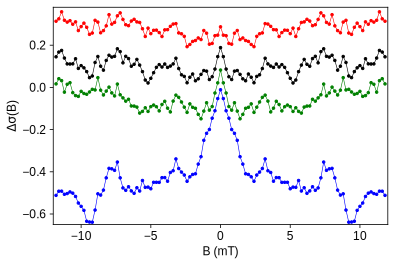

In [107]:
# -6 Vbg
xmin, xmax = -12, 12
Msize = 5
LW = 0.6
plt.figure(figsize=(6, 4))
plt.plot(np.ma.masked_outside(bsymm830base6, xmin, xmax), Gsymm830base6, '.-b', label='Base Temp', ms=Msize, lw=LW)
plt.plot(np.ma.masked_outside(bsymm8303006, xmin, xmax), Gsymm8303006 + 0.1, '.-g', label='300 mK', ms=Msize, lw=LW)
plt.plot(np.ma.masked_outside(bsymm8305006, xmin, xmax), Gsymm8305006 + 0.2, '.-k', label='500 mK', ms=Msize, lw=LW)
plt.plot(np.ma.masked_outside(bsymm8307006, xmin, xmax), Gsymm8307006 + 0.3, '.-r', label='700 mK', ms=Msize, lw=LW)

# tauasy = 50e-12
# tauso = 3e-12
# bv = np.linspace(0.00001, 0.025, 701)
# bvs = np.concatenate((-1*bv[::-1], bv[1:]))
# dsbase = dsigma_WAL(bv, 800e-12, tauasy, tauso)
# ybase = np.concatenate((dsbase[::-1], dsbase[1:]))
# plt.plot(bvs*1000, ybase/esqh, 'b--')

# ds300 = dsigma_WALn6(bv, 120e-12, tauasy, tauso)
# y300 = np.concatenate((ds300[::-1], ds300[1:]))
# plt.plot(bvs*1000, y300/esqh, 'g--')

# ds500 = dsigma_WALn6(bv, 70e-12, tauasy, tauso)
# y500 = np.concatenate((ds500[::-1], ds500[1:]))
# plt.plot(bvs*1000, y500/esqh, 'k--')

# ds700 = dsigma_WALn6(bv, 25e-12, tauasy, tauso)
# y700 = np.concatenate((ds700[::-1], ds700[1:]))
# plt.plot(bvs*1000, y700/esqh, 'r--')

plt.axis((xmin, xmax, -0.65, 0.38))
# plt.legend(['700 mK', '500 mK', '300 mK', '25 mK'])
plt.xlabel('B (mT)')
plt.ylabel('$\Delta\sigma$(B)')
# plt.savefig(figfile + 'WALfitplot_Vbg-6_39-38_3ps_largefield_v2.svg', dpi=300, bbox_inches='tight')

# Try with lmfit

In [108]:
from lmfit import Parameters, Minimizer, fit_report, minimize

In [109]:
hbar = (6.626e-34/(2*np.pi))

In [110]:
# Just some estimates on the non-varying parameters
# sigma/ne mobility
mu = sigman2/(1.602e-19*0.6902187745245999e16)
print(mu*10**4)

# From this we can get a scattering time of approximately
vf = 1e5
tau = mu*hbar*np.sqrt(np.pi*0.6902187745245999e16)/(1.602e-19*vf)
print(tau*10**12) # in ps

15982.018510632675
1.5492053969654063


In [111]:
# this corresponds with a diffusion constant
D = 1e5**2*tau/2
D

0.007746026984827032

## Just fitting the base-temperature curve

In [112]:
# construct the model
params = Parameters()
params.add('mu', value=15982, vary=False)
params.add('n', value=0.69021, vary=False)
params.add('vF', value=5e5, vary=False)   # adjusted upward, in conjunction with Alex's suggestion that it may be largeer than 1e5
params.add('tauphi', value=40, min=0.01, max=500)
params.add('tauasy', value=10, min=0.01, max=200)
params.add('tausym', value=10, min=0.01, max=200)

def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

def dsigma_WAL(B, mu, n, vF, tauphi, tauasy, tausym):  
    mu = mu/10**4  # mu is in cm^2/Vs
    n = n*10**16  # n in 10^12 cm^-2
    tau = mu*hbar*np.sqrt(np.pi*n)/(1.602e-19*vF)
    D = vF**2*tau/2
    taubinv = 4*D*1.602e-19*B/hbar
    tauphi = tauphi*10**-12
    tauasy = tauasy*10**-12
    tausym = tausym*10**-12
    tauso = (tauasy**-1 + tausym**-1)**-1

    return -1/(2*np.pi)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))

def residuals(params, B, data):
    p = params.valuesdict()
    mu = p['mu']
    n = p['n']
    vF = p['vF']
    tauphi = p['tauphi']
    tauasy = p['tauasy']
    tausym = p['tausym']
    
    dsigma = dsigma_WAL(B/1000, mu, n, vF, tauphi, tauasy, tausym)
    
#     # normal residuals
#     return (dsigma - data)

## or the weighted residuals, with some error assumed in the higher-field data but most in the shoulder region (but different temperatures weighed the same)
    N = len(dsigma)
    Nlow = 10
    Nmid = 20
    eps = np.array((Nlow*[1] + Nmid*[8] + (N-Nlow - Nmid)*[2]))  ## v1: tauasy = , tausym =   ####
    res = np.divide((dsigma - data), eps)
    return res

In [113]:
Bd = bsymm830base[121:]
Gd = Gsymm830base[121:]

In [114]:
results = minimize(residuals, params, args=(Bd[:], Gd[:]))

In [115]:
d = dict(zip(results.params.keys(), [results.params[key].value for key in results.params.keys()]))  # form a dictionary of the parameters
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 120
    # variables        = 3
    chi-square         = 0.02935939
    reduced chi-square = 2.5093e-04
    Akaike info crit   = -991.876149
    Bayesian info crit = -983.513674
[[Variables]]
    mu:      15982 (fixed)
    n:       0.69021 (fixed)
    vF:      500000 (fixed)
    tauphi:  48.8448434 +/- 2.65602279 (5.44%) (init = 40)
    tauasy:  2.53716914 +/- 1137.75434 (44843.46%) (init = 10)
    tausym:  2.53970371 +/- 2271.44907 (89437.56%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tauasy, tausym) = -1.000
    C(tauphi, tauasy) =  0.633
    C(tauphi, tausym) = -0.633


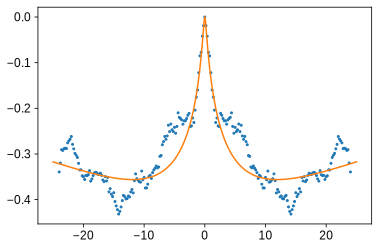

In [116]:
plt.figure()
plt.plot(bsymm830base, Gsymm830base, '.')
Bv = np.linspace(0.01, 25, 701)
Bvs = np.concatenate((-1*Bv[::-1], Bv))
G0 = dsigma_WAL(Bv/1000, **d)
Gf = np.concatenate((G0[::-1], G0))
plt.plot(Bvs, Gf)

## Attempting a Bayesian analysis of the relevant parameters using emcee

### First, try the emcee method contained in lmfit.

In [ ]:
# Make a Model instead of what I had before


## Now constraining all temps to have the same $\tau_{so}$, $\tau_{asy}$ (but varying $\tau_{\phi}$ between temps)

In [890]:
# construct the model
params = Parameters()
params.add('mu', value=15982, vary=False)
params.add('n', value=0.69021, vary=False)
params.add('vF', value=3e5, vary=False)
params.add('tauphi_1', value=200, min=0.01, max=500)
params.add('tauphi_2', value=100, min=0.01, max=500)
params.add('tauphi_3', value=50, min=0.01, max=500)
params.add('tauphi_4', value=10, min=0.01, max=500)
params.add('tauasy', value=20, min=0.01, max=200)
params.add('tausym', value=2, min=0.01, max=200)

def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

def dsigma_WAL(B, mu, n, vF, tauphi, tauasy, tausym):  
    mu = mu/10**4  # mu is in cm^2/Vs
    n = n*10**16  # n in 10^12 cm^-2
    tau = mu*hbar*np.sqrt(np.pi*n)/(1.602e-19*vF)
    D = vF**2*tau/2
    taubinv = 4*D*1.602e-19*B/hbar
    tauphi = tauphi*10**-12
    tauasy = tauasy*10**-12
    tausym = tausym*10**-12
    tauso = (tauasy**-1 + tausym**-1)**-1

    return -1/(2*np.pi)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))

def residuals(params, B, data):
    p = params.valuesdict()
    mu = p['mu']
    n = p['n']
    vF = p['vF']
    tauphi_1, tauphi_2, tauphi_3, tauphi_4 = p['tauphi_1'], p['tauphi_2'], p['tauphi_3'], p['tauphi_4']
    tauasy = p['tauasy']
    tausym = p['tausym']
    nB = int(len(B)/4)
    
    dsigma1 = dsigma_WAL(B[:nB]/1000, mu, n, vF, tauphi_1, tauasy, tausym)
    dsigma2 = dsigma_WAL(B[nB:2*nB]/1000, mu, n, vF, tauphi_2, tauasy, tausym)
    dsigma3 = dsigma_WAL(B[2*nB:3*nB]/1000, mu, n, vF, tauphi_3, tauasy, tausym)
    dsigma4 = dsigma_WAL(B[3*nB:]/1000, mu, n, vF, tauphi_4, tauasy, tausym)
    
    ## Either return the direct residuals: gives tauasy ~ tausym = 2.8
#     dsigma = np.concatenate((dsigma1, dsigma2, dsigma3, dsigma4))
#     return (dsigma - data)
    
    ## or the weighted residuals, with the most error assumed in the high-temp data
#     eps1, eps2, eps3, eps4 = 0.11, 2, 2, 5
#     res = np.concatenate(((dsigma1 - data[:nB])**2/eps1**2, (dsigma2 - data[nB:2*nB])**2/eps2**2, (dsigma3 - data[2*nB:3*nB])**2/eps3**2, (dsigma4 - data[3*nB:])**2/eps4**2))
#     return res

    ## or the weighted residuals, with the most error assumed in the higher-field data (but different temperatures weighed the same)
#     eps = np.linspace(1, 3, int(len(B)/4))  ## v1: tauasy = 11, tausym = 0.01   #### the data varies a lot depending on the exact weights here
#     eps = np.linspace(1, 1.8, int(len(B)/4))  ## v2: tauasy = 1.8, tausym = 16.4
#     eps = np.linspace(1, 2.3, int(len(B)/4))  ## v3: tauasy = 9.4, tausym = 0.27
#     res = np.concatenate((np.divide((dsigma1 - data[:nB])**2, eps**2), np.divide((dsigma2 - data[nB:2*nB])**2, eps**2), np.divide((dsigma3 - data[2*nB:3*nB])**2, eps**2), np.divide((dsigma4 - data[3*nB:])**2, eps**2)))
#     return res

    ## or the weighted residuals, with some error assumed in the higher-field data but most in the shoulder region (but different temperatures weighed the same)
    N = len(dsigma1)
    Nlow = 10
    Nmid = 15
    eps = np.array((Nlow*[1] + Nmid*[10] + (N-Nlow - Nmid)*[2]))  ## v1: tauasy = , tausym =   ####
    res = np.concatenate((np.divide((dsigma1 - data[:nB]), eps), np.divide((dsigma2 - data[nB:2*nB]), eps), np.divide((dsigma3 - data[2*nB:3*nB]), eps), np.divide((dsigma4 - data[3*nB:]), eps)))
    return res

In [891]:
Bd2, Gd2 = bsymm830300[121:], Gsymm830300[121:]
Bd3, Gd3 = bsymm830500[121:], Gsymm830500[121:]
Bd4, Gd4 = bsymm830700[121:], Gsymm830700[121:]
Bdf = np.concatenate((Bd, Bd2, Bd3, Bd4))
Gdf = np.concatenate((Gd, Gd2, Gd3, Gd4))

In [892]:
results = minimize(residuals, params, args=(Bdf, Gdf))
d = dict(zip(results.params.keys(), [results.params[key].value for key in results.params.keys()]))
dfix = dict(zip(list(results.params.keys())[:3], [results.params[key].value for key in list(results.params.keys())[:3]]))
dtau = dict(zip(list(results.params.keys())[-2:], [results.params[key].value for key in list(results.params.keys())[-2:]]))
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 480
    # variables        = 6
    chi-square         = 0.12889637
    reduced chi-square = 2.7193e-04
    Akaike info crit   = -3934.81567
    Bayesian info crit = -3909.77295
[[Variables]]
    mu:        15982 (fixed)
    n:         0.69021 (fixed)
    vF:        300000 (fixed)
    tauphi_1:  72.1976528 +/- 3.58634256 (4.97%) (init = 200)
    tauphi_2:  36.3523624 +/- 1.85505190 (5.10%) (init = 100)
    tauphi_3:  15.6987740 +/- 0.80946148 (5.16%) (init = 50)
    tauphi_4:  7.13828810 +/- 0.40319939 (5.65%) (init = 10)
    tauasy:    8.83084546 +/- 1.49952168 (16.98%) (init = 20)
    tausym:    0.94311106 +/- 0.20035599 (21.24%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(tauasy, tausym)     = -0.927
    C(tauphi_1, tauasy)   =  0.821
    C(tauphi_1, tauphi_2) =  0.805
    C(tauphi_2, tauasy)   =  0.785
    C(tauphi_1, tauphi_3) =  0.733
    C(tauphi_2,

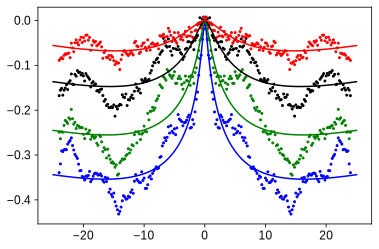

In [893]:
plt.figure()
plt.plot(bsymm830base, Gsymm830base, '.b')
plt.plot(bsymm830300, Gsymm830300, '.g')
plt.plot(bsymm830500, Gsymm830500, '.k')
plt.plot(bsymm830700, Gsymm830700, '.r')
Bv = np.linspace(0.01, 25, 701)
Bvs = np.concatenate((-1*Bv[::-1], Bv))
G01 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_1'])
Gf1 = np.concatenate((G01[::-1], G01))
plt.plot(Bvs, Gf1, 'b')
G02 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_2'])
Gf2 = np.concatenate((G02[::-1], G02))
plt.plot(Bvs, Gf2, 'g')
G03 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_3'])
Gf3 = np.concatenate((G03[::-1], G03))
plt.plot(Bvs, Gf3, 'k')
G04 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_4'])
Gf4 = np.concatenate((G04[::-1], G04))
plt.plot(Bvs, Gf4, 'r')

In [894]:
print('tauso: ', str((d['tauasy']**-1 + d['tausym']**-1)**-1) + ' ps')
print('tau: ', str(d['mu']/10**4*hbar*np.sqrt(np.pi*d['n']*10**16)/(1.602e-19*d['vF'])*10**12) + ' ps')

tauso:  0.8521081521530379 ps
tau:  0.5163979184536742 ps


A few notes: all of these parameters (except for some of the $\tau_\phi$ parameters) are pretty highly correlated. Take, for example, $\tau_{asy}$ and $\tau_{sym}$, which have a correlation of -1. It's not expected that $\tau_{\phi1}$ and $\tau_{\phi2}$ are highly correlated, though it's likely due to the fact that changing $\tau_{sym}$, $\tau_{asy}$ changes all the curves.

Secondly, $\tau_{sym}$, $\tau_{asy}$ have very large uncertainties. The parameters can easily be changed by varying $v_F$, the $\tau_\phi$ variables, any of the initial guesses to the parameters, the range of data used, the weight of data at low vs. high fields or low vs. high temperatures. I have been able to get, through these methods, large differences between the values (sometimes $\tau_{asy}$ is lower, but usually it's higher), as large as 200-300 ps for one parameter and 0.01 ps for the other parameter. The uncertainties tend to go down slightly when the two parameters split, though they are always >100%. (So in the parameter range I was using before lmfit, I couldn't bring $\tau_{asy}$ down much without the results differing a lot, though it seems likely that it can be the same order of magnitude as $\tau_{sym}$

It seems safe to say that the results here are not able to determine a large difference between Rashba and Ising/Kane-Mele SOC. We can either show a plot with a few different example parameters for these widely different values, or leave it at this. Perhaps higher fields or more averaging would make this plot better, though it seems that our small device size, its low Fermi velocity, its complexity with the moire bands and such, and the amount of disorder, prevent us from getting super optimal results. However, perhaps we can get an approximate range for the total $\tau_{so}$. 

# Another look at $\tau_\phi$ through UCF

In [152]:
filesucf1 = sorted(glob.glob('data/2020-04-27/#*/'))[9:39]

['data/2020-04-27/#010_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.74_10nA_01-06-14/',
 'data/2020-04-27/#011_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.76_10nA_01-21-35/',
 'data/2020-04-27/#012_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.78_10nA_01-36-55/',
 'data/2020-04-27/#013_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.80_10nA_01-52-15/',
 'data/2020-04-27/#014_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.82_10nA_02-07-35/',
 'data/2020-04-27/#015_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.84_10nA_02-22-55/',
 'data/2020-04-27/#016_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.86_10nA_02-38-16/',
 'data/2020-04-27/#017_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.88_10nA_02-53-36/',
 'data/2020-04-27/#018_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.90_10nA_03-08-56/',
 'data/2020-04-27/#019_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.92_10nA_03-24-15/',
 'data/2020-04-27/#020_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.94_10nA_03-39-35/',
 'data/2020-04-27/#02

In [154]:
d1ucf = qc.load_data(filesucf1[0][:-1])
d1ucf

DataSet:
   location = 'data/2020-04-27/#010_W5_865_40-39_830_39-38_baseT_UCFfieldsw_Vbg-1.74_10nA_01-06-14'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Setpoint | count_set    | count        | (900,)
   Measured | lockin830_X  | X            | (900,)
   Measured | lockin830_Y  | Y            | (900,)
   Measured | lockin865_X  | X            | (900,)
   Measured | lockin865_Y  | Y            | (900,)
   Measured | time0        | time0        | (900,)
   Measured | triton_field | field        | (900,)

Try on one gate point, at -1.74 V

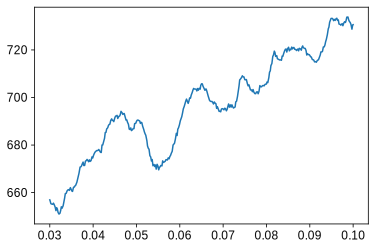

In [163]:
plt.figure()
plt.plot(d1ucf.triton_field, d1ucf.lockin865_X[:]/10e-9)

In [191]:
b[-1]  #0.03 to 0.1

0.100003

In [214]:
dlast = np.where(np.isnan(d1ucf.triton_field))[0][0]
br = d1ucf.triton_field[:dlast]
Rr = d1ucf.lockin865_X[:dlast]/10e-9
Gr = 1/Rr/esqh

b = np.linspace(0.03, 0.1, 401)
G = np.interp(b, br, Gr)

# subtract a linear slope
m, intc = np.polyfit(b, G, 1)
Gc = G - (m*b + intc)

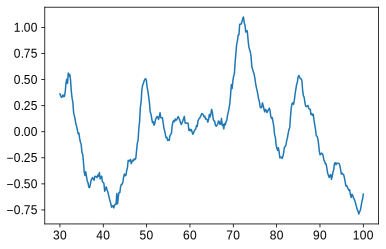

In [291]:
plt.figure()
plt.plot(b, Gc) # this gives a sense of the size of the fluctuations (~e^2/h, which is consistent with UCF)

In [215]:
from scipy.signal import correlate, convolve

In [217]:
acorr0 = correlate(Gc, Gc)
acorr = acorr0[int(len(acorr0)/2):]
db = b - b[0]
len(acorr)

401

In [218]:
# try also the data without plane subtraction
acorr0_2 = correlate(G, G)
acorr_2 = acorr0_2[int(len(acorr0_2)/2):]

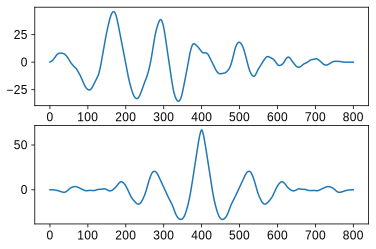

In [219]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(convolve(Gc, Gc))  # not convolve. The difference is f(t)*f(t - tau) vs. f(t)*f(t + tau) for correlate
ax[1].plot(correlate(Gc, Gc)) # use this. Notice that it's symmetric

In [223]:
db[50]*1000

8.75

In [229]:
D

0.007746026984827032

In [232]:
der = np.gradient(acorr)/np.gradient(db)
dbmin = db[np.argmin(der[:50])]
print('Inflection point: {:.2f} mT'.format(dbmin*1000))
tauphi = 3*hbar/(2*1.602e-19*D*dbmin)
print('tauphi: {:.3f} ps'.format(tauphi*10**12))

Inflection point: 3.15 mT
tauphi: 40.468 ps


Text(0, 0.5, 'Derivative')

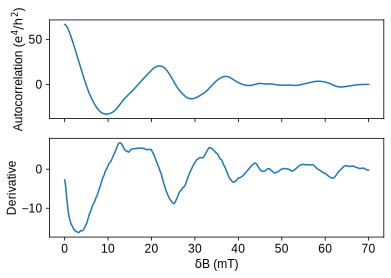

In [233]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(db*1000, acorr)
# plt.plot(db, acorr_2)  # doesn't work. The linear slope kills it

ax[1].plot(db*1000, np.gradient(acorr)/np.gradient(db*1000))

ax[1].set_xlabel('$\delta$B (mT)')
ax[0].set_ylabel('Autocorrelation ($e^4/h^2$)')
ax[1].set_ylabel('Derivative')

In [246]:
Acorr.shape

(30, 401)

In [386]:
b = np.linspace(30, 100, 401)
db = b - b[0]
Acorr = np.zeros((len(filesucf1), len(db)))
Acorrder = np.zeros((len(filesucf1), len(db)))
bminarr = np.zeros(len(filesucf1))
curr = 10e-9

for i, f in enumerate(filesucf1):
    d = qc.load_data(f[:-1])
    dlast = np.where(np.isnan(d.triton_field))[0][0]
    b0 = d.triton_field[:dlast]*1000  # in mT
    R = np.interp(b, b0, d.lockin865_X[:dlast]/curr)
    G = 1/R/esqh  # use units of e^2/h
    
    # remove a linear slope
    theta, intc = np.polyfit(db, G, 1)
    Gc = G - (theta*db + intc)
    
    acorr0 = correlate(Gc, Gc)
    acorr = acorr0[int(len(acorr0)/2):]
    Acorr[i, :] = acorr
    
    der = np.gradient(gaussian_filter(acorr, 14))/np.gradient(db)
    Acorrder[i, :] = der
    
    bminarr[i] = db[np.argmin(der[:80])]

4.024999999999999
3.8500000000000014
3.325000000000003
4.024999999999999
2.625
5.075000000000003


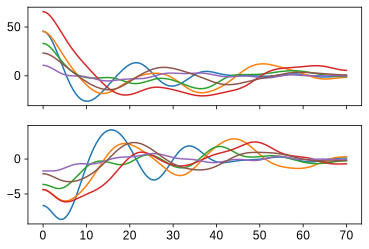

In [387]:
fig, ax = plt.subplots(2, 1, sharex=True)

for i in range(6):
    indx = 2*i
    ax[0].plot(db, gaussian_filter(Acorr[indx, :], 14), label='{:.2f} V'.format(-1.74 - 0.02*indx))
    ax[1].plot(db, gaussian_filter(Acorrder[indx, :], 14), label='{:.2f} V'.format(-1.74 - 0.02*indx))
    print(bminarr[indx])
    
# plt.legend()
# plt.xlim((0, 25))

In [388]:
bminav = np.average(bminarr)
deltabminav = np.std(bminarr)
print('Inflection point: {:.2f} +/- {:.2f} mT'.format(bminav, deltabminav))
tauphi = 3*hbar/(2*1.602e-19*D*(bminav/1000))
dtauphi = tauphi/bminav*deltabminav
print('tauphi: {:.3f} +/- {:.3f} ps'.format(tauphi*10**12, dtauphi*10**12))

Inflection point: 3.68 +/- 0.76 mT
tauphi: 34.632 +/- 7.107 ps


18.95 is not a value in the array
Plotted 19.13 instead
Inflection point: 3.15 mT
tauphi: 40.468 ps


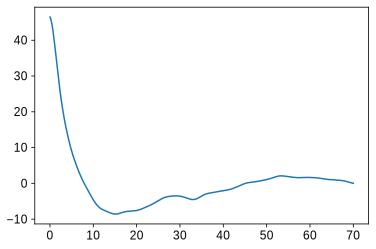

In [389]:
plt.figure()   # try another approach by using the average of all autocorrelations and use the HWHM
Acorrav = np.average(Acorr, axis=0)
plt.plot(db, Acorrav)
height = Acorrav[0] - np.min(Acorrav)
bhwhm = db[npd.val_to_index([np.min(Acorrav) + height/2], Acorrav)[0]]
print('Half width at half max: {:.2f} mT'.format(bhwhm))
tauphihwhm = 3*hbar/(2*1.602e-19*D*(bhwhm/1000))
print('tauphi: {:.3f} ps'.format(tauphihwhm*10**12))

## Try using $\tau_{\phi 1} = 40.5$ ps to fit the peaks 

In [900]:
# construct the model
params = Parameters()
params.add('mu', value=15982, vary=False)
params.add('n', value=0.69021, vary=False)
params.add('vF', value=4.5e5, vary=False)
params.add('tauphi_1', value=40.5, vary=False)
params.add('tauphi_2', value=30, min=0.01, max=40)
params.add('tauphi_3', value=20, min=0.01, max=40)
params.add('tauphi_4', value=15, min=0.01, max=40)
params.add('tauasy', value=1, min=0.01, max=100)
params.add('tausym', value=1, min=0.01, max=100)

def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

def dsigma_WAL(B, mu, n, vF, tauphi, tauasy, tausym):  
    mu = mu/10**4  # mu is in cm^2/Vs
    n = n*10**16  # n in 10^12 cm^-2
    tau = mu*hbar*np.sqrt(np.pi*n)/(1.602e-19*vF)
    D = vF**2*tau/2
    taubinv = 4*D*1.602e-19*B/hbar
    tauphi = tauphi*10**-12
    tauasy = tauasy*10**-12
    tausym = tausym*10**-12
    tauso = (tauasy**-1 + tausym**-1)**-1

    return -1/(2*np.pi)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))

def residuals(params, B, data):
    p = params.valuesdict()
    mu = p['mu']
    n = p['n']
    vF = p['vF']
    tauphi_1, tauphi_2, tauphi_3, tauphi_4 = p['tauphi_1'], p['tauphi_2'], p['tauphi_3'], p['tauphi_4']
    tauasy = p['tauasy']
    tausym = p['tausym']
    nB = int(len(B)/4)
    
    dsigma1 = dsigma_WAL(B[:nB]/1000, mu, n, vF, tauphi_1, tauasy, tausym)
    dsigma2 = dsigma_WAL(B[nB:2*nB]/1000, mu, n, vF, tauphi_2, tauasy, tausym)
    dsigma3 = dsigma_WAL(B[2*nB:3*nB]/1000, mu, n, vF, tauphi_3, tauasy, tausym)
    dsigma4 = dsigma_WAL(B[3*nB:]/1000, mu, n, vF, tauphi_4, tauasy, tausym)
    
    ## direct residuals: gives 
    dsigma = np.concatenate((dsigma1, dsigma2, dsigma3, dsigma4))
    return (dsigma - data)  # supposed to be squared or not? It seems not.
    

In [901]:
Bd2, Gd2 = bsymm830300[121:], Gsymm830300[121:]
Bd3, Gd3 = bsymm830500[121:], Gsymm830500[121:]
Bd4, Gd4 = bsymm830700[121:], Gsymm830700[121:]
Bdf = np.concatenate((Bd, Bd2, Bd3, Bd4))
Gdf = np.concatenate((Gd, Gd2, Gd3, Gd4))

In [902]:
results = minimize(residuals, params, args=(Bdf, Gdf))
d = dict(zip(results.params.keys(), [results.params[key].value for key in results.params.keys()]))
dfix = dict(zip(list(results.params.keys())[:3], [results.params[key].value for key in list(results.params.keys())[:3]]))
dtau = dict(zip(list(results.params.keys())[-2:], [results.params[key].value for key in list(results.params.keys())[-2:]]))
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 480
    # variables        = 5
    chi-square         = 0.50095796
    reduced chi-square = 0.00105465
    Akaike info crit   = -3285.20922
    Bayesian info crit = -3264.34029
[[Variables]]
    mu:        15982 (fixed)
    n:         0.69021 (fixed)
    vF:        450000 (fixed)
    tauphi_1:  40.5 (fixed)
    tauphi_2:  19.6406512 +/- 0.58098043 (2.96%) (init = 30)
    tauphi_3:  8.77904859 +/- 0.29172632 (3.32%) (init = 20)
    tauphi_4:  4.15583615 +/- 0.18579942 (4.47%) (init = 15)
    tauasy:    1.68840608 +/- 1.71818237 (101.76%) (init = 1)
    tausym:    3.41607303 +/- 11.2336027 (328.85%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(tauasy, tausym)     = -1.000
    C(tauphi_2, tauphi_3) =  0.349
    C(tauphi_2, tausym)   =  0.302
    C(tauphi_2, tauasy)   = -0.286
    C(tauphi_3, tauphi_4) =  0.247
    C(tauphi_2, tauphi_4) =  0.216
    C(tauphi_4

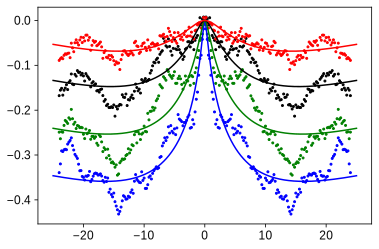

In [903]:
plt.figure()
plt.plot(bsymm830base, Gsymm830base, '.b')
plt.plot(bsymm830300, Gsymm830300, '.g')
plt.plot(bsymm830500, Gsymm830500, '.k')
plt.plot(bsymm830700, Gsymm830700, '.r')
Bv = np.linspace(0.01, 25, 701)
Bvs = np.concatenate((-1*Bv[::-1], Bv))
G01 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_1'])
Gf1 = np.concatenate((G01[::-1], G01))
plt.plot(Bvs, Gf1, 'b')
G02 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_2'])
Gf2 = np.concatenate((G02[::-1], G02))
plt.plot(Bvs, Gf2, 'g')
G03 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_3'])
Gf3 = np.concatenate((G03[::-1], G03))
plt.plot(Bvs, Gf3, 'k')
G04 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_4'])
Gf4 = np.concatenate((G04[::-1], G04))
plt.plot(Bvs, Gf4, 'r')

In [725]:
print('tauso: ', str((d['tauasy']**-1 + d['tausym']**-1)**-1) + ' ps')
print('tau: ', str(d['mu']/10**4*hbar*np.sqrt(np.pi*d['n']*10**16)/(1.602e-19*d['vF'])*10**12) + ' ps')

tauso:  1.1299328202672252 ps
tau:  0.3442652789691162 ps


Now the range is (just considering the variation in $v_F$, as there are also variations given the change in measured field range, the variation in $\tau_\phi$, and such): (with $v_F = 3\times 10^5$) $\tau_{asy} \approx 2.18$ ps, $\tau_{asy} \approx \tau_{sym}$, and $\tau_{so} \approx 1.09$ ps; to (with $v_F = 5\times 10^5$) $\tau_{asy} \approx 5$ ps, $\tau_{sym} \approx 0.52 ps$, and $\tau_{so} \approx 0.47$ ps.  This corresponds to a range of $\tau_{asy}/\tau_{sym} \approx$ 1-10, $\sqrt{\tau_{asy}/\tau_{sym}} \approx$ 1-3

The fit didn't work at all for $v_F < 3\times 10^5$

Just to check if these field ranges are reasonable, we can check the 

In [588]:
tau = d['mu']/10**4*hbar*np.sqrt(np.pi*d['n']*10**16)/(1.602e-19*d['vF'])
print(tau)
lmfp = d['vF']*tau
print(lmfp)
Bmax = 6.626e-34/1.602e-19/lmfp**2
print('Bmax: ', Bmax*1000)  # theoretically the max relevant field, in mT. It's independent of v_F.

3.4426527896911616e-13
1.5491937553610226e-07
Bmax:  172.33656975584378


## Try weighing the center a little higher

In [753]:
# construct the model
params = Parameters()
params.add('mu', value=15982, vary=False)
params.add('n', value=0.69021, vary=False)
params.add('vF', value=5e5, vary=False)
params.add('tauphi_1', value=40.5, vary=False)
params.add('tauphi_2', value=30, min=0.01, max=40)
params.add('tauphi_3', value=20, min=0.01, max=40)
params.add('tauphi_4', value=15, min=0.01, max=40)
params.add('tauasy', value=10, min=0.01, max=100)
params.add('tausym', value=1, min=0.01, max=100)

def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

def dsigma_WAL(B, mu, n, vF, tauphi, tauasy, tausym):  
    mu = mu/10**4  # mu is in cm^2/Vs
    n = n*10**16  # n in 10^12 cm^-2
    tau = mu*hbar*np.sqrt(np.pi*n)/(1.602e-19*vF)
    D = vF**2*tau/2
    taubinv = 4*D*1.602e-19*B/hbar
    tauphi = tauphi*10**-12
    tauasy = tauasy*10**-12
    tausym = tausym*10**-12
    tauso = (tauasy**-1 + tausym**-1)**-1

    return -1/(2*np.pi)*(F(taubinv/(tauphi**-1)) - F(taubinv/(tauphi**-1 + 2*tauasy**-1)) - 2*F(taubinv/(tauphi**-1 + tauso**-1)))

def residuals(params, B, data):
    p = params.valuesdict()
    mu = p['mu']
    n = p['n']
    vF = p['vF']
    tauphi_1, tauphi_2, tauphi_3, tauphi_4 = p['tauphi_1'], p['tauphi_2'], p['tauphi_3'], p['tauphi_4']
    tauasy = p['tauasy']
    tausym = p['tausym']
    nB = int(len(B)/4)
    
    dsigma1 = dsigma_WAL(B[:nB]/1000, mu, n, vF, tauphi_1, tauasy, tausym)
    dsigma2 = dsigma_WAL(B[nB:2*nB]/1000, mu, n, vF, tauphi_2, tauasy, tausym)
    dsigma3 = dsigma_WAL(B[2*nB:3*nB]/1000, mu, n, vF, tauphi_3, tauasy, tausym)
    dsigma4 = dsigma_WAL(B[3*nB:]/1000, mu, n, vF, tauphi_4, tauasy, tausym)
    
    ## Either return the direct residuals: gives tauasy ~ tausym = 2.8
#     dsigma = np.concatenate((dsigma1, dsigma2, dsigma3, dsigma4))
#     return (dsigma - data)
    
    ## or the weighted residuals, with the most error assumed in the high-temp data
#     eps1, eps2, eps3, eps4 = 0.11, 2, 2, 5
#     res = np.concatenate(((dsigma1 - data[:nB])/eps1, (dsigma2 - data[nB:2*nB])/eps2, (dsigma3 - data[2*nB:3*nB])/eps3, (dsigma4 - data[3*nB:])/eps4))
#     return res

    ## or the weighted residuals, with the most error assumed in the higher-field data (but different temperatures weighed the same)
#     eps = np.linspace(1, 3, int(len(B)/4))  ## v1: tauasy = 11, tausym = 0.01   #### the data varies a lot depending on the exact weights here
#     eps = np.linspace(1, 1.8, int(len(B)/4))  ## v2: tauasy = 1.8, tausym = 16.4
#     eps = np.linspace(1, 2.3, int(len(B)/4))  ## v3: tauasy = 9.4, tausym = 0.27
#     res = np.concatenate((np.divide((dsigma1 - data[:nB]), eps), np.divide((dsigma2 - data[nB:2*nB]), eps), np.divide((dsigma3 - data[2*nB:3*nB]), eps), np.divide((dsigma4 - data[3*nB:]), eps)))
#     return res

#     ## or the weighted residuals, with some error assumed in the higher-field data but most in the shoulder region (but different temperatures weighed the same)
    ## This one seems fairly reliable in that it doesn't have any strange behavior (like tau_sym = 100 ps)
    N = len(dsigma1)
    Nlow = 10
    Nmid = 15
    eps = np.array((Nlow*[1] + Nmid*[8] + (N-Nlow - Nmid)*[3]))  ## v1: tauasy = , tausym =   ####
    res = np.concatenate((np.divide((dsigma1 - data[:nB]), eps), np.divide((dsigma2 - data[nB:2*nB]), eps), np.divide((dsigma3 - data[2*nB:3*nB]), eps), np.divide((dsigma4 - data[3*nB:]), eps)))
    return res

In [754]:
Bd2, Gd2 = bsymm830300[121:], Gsymm830300[121:]
Bd3, Gd3 = bsymm830500[121:], Gsymm830500[121:]
Bd4, Gd4 = bsymm830700[121:], Gsymm830700[121:]
Bdf = np.concatenate((Bd, Bd2, Bd3, Bd4))
Gdf = np.concatenate((Gd, Gd2, Gd3, Gd4))

In [755]:
results = minimize(residuals, params, args=(Bdf, Gdf))
d = dict(zip(results.params.keys(), [results.params[key].value for key in results.params.keys()]))
dfix = dict(zip(list(results.params.keys())[:3], [results.params[key].value for key in list(results.params.keys())[:3]]))
dtau = dict(zip(list(results.params.keys())[-2:], [results.params[key].value for key in list(results.params.keys())[-2:]]))
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 480
    # variables        = 5
    chi-square         = 0.06561892
    reduced chi-square = 1.3815e-04
    Akaike info crit   = -4260.88512
    Bayesian info crit = -4240.01619
[[Variables]]
    mu:        15982 (fixed)
    n:         0.69021 (fixed)
    vF:        500000 (fixed)
    tauphi_1:  40.5 (fixed)
    tauphi_2:  21.2173282 +/- 0.62198482 (2.93%) (init = 30)
    tauphi_3:  9.09408396 +/- 0.32009209 (3.52%) (init = 20)
    tauphi_4:  4.26761483 +/- 0.20950910 (4.91%) (init = 15)
    tauasy:    4.06232165 +/- 0.63570239 (15.65%) (init = 10)
    tausym:    0.77408301 +/- 0.17324747 (22.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(tauasy, tausym)     = -0.973
    C(tauphi_2, tauasy)   =  0.349
    C(tauphi_2, tauphi_3) =  0.314
    C(tauphi_4, tausym)   =  0.278
    C(tauphi_3, tauphi_4) =  0.234
    C(tauphi_2, tausym)   = -0.224
    C(tauphi_2,

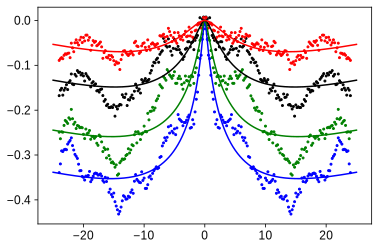

In [756]:
plt.figure()
plt.plot(bsymm830base, Gsymm830base, '.b')
plt.plot(bsymm830300, Gsymm830300, '.g')
plt.plot(bsymm830500, Gsymm830500, '.k')
plt.plot(bsymm830700, Gsymm830700, '.r')
Bv = np.linspace(0.01, 25, 701)
Bvs = np.concatenate((-1*Bv[::-1], Bv))
G01 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_1'])
Gf1 = np.concatenate((G01[::-1], G01))
plt.plot(Bvs, Gf1, 'b')
G02 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_2'])
Gf2 = np.concatenate((G02[::-1], G02))
plt.plot(Bvs, Gf2, 'g')
G03 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_3'])
Gf3 = np.concatenate((G03[::-1], G03))
plt.plot(Bvs, Gf3, 'k')
G04 = dsigma_WAL(Bv/1000, **dfix, **dtau, tauphi=d['tauphi_4'])
Gf4 = np.concatenate((G04[::-1], G04))
plt.plot(Bvs, Gf4, 'r')

In [757]:
print('tauso: ', str((d['tauasy']**-1 + d['tausym']**-1)**-1) + ' ps')
print('tau: ', str(d['mu']/10**4*hbar*np.sqrt(np.pi*d['n']*10**16)/(1.602e-19*d['vF'])*10**12) + ' ps')

tauso:  0.6501883947573319 ps
tau:  0.30983875107220454 ps


### Now try with these values to get the $\tau_\phi$ from each curve by subtracting the WAL peak fits (using the unaveraged, nonsymmetrized data in an autocorrelation function, as was done in the Bockrath papers).

Start with base temperature

In [529]:
bhere = barr*1000 - 1.2
dbcurve = bhere - bhere[0]
dGn2_830_subbase = dGn2_830_base - dGn2_830_900 - dsigma_WAL(np.abs(bhere)/1000, **dfix, **dtau, tauphi=d['tauphi_1'])
Acorrcurve_base = np.zeros(dGn2_830_subbase.shape)
Acorrder_base = np.zeros(dGn2_830_subbase.shape)
bminarr_base = np.zeros(dGn2_830_subbase.shape[0])
for i in range(dGn2_830_subbase.shape[0]):
    G = dGn2_830_subbase[i, :]
    
    ## uncomment if you want line subtraction (and make G above into G0). It happens to work well so far when not subtracting
#     sl, intc = np.polyfit(bhere, G0, 1)  # subtract a line
#     G = G0 - (bhere*sl + intc)

    acorr0 = correlate(G, G)
    acorr = acorr0[int(len(acorr0)/2):]
    Acorrcurve_base[i, :] = acorr
    
    der = np.gradient(gaussian_filter(acorr, 14))/np.gradient(dbcurve)
    Acorrder_base[i, :] = der
    
    bminarr_base[i] = dbcurve[np.argmin(der[:80])]

In [530]:
print(dbcurve[60], dbcurve[140])

11.999999999999998 28.0


68.70 is not a value in the array
Plotted 69.51 instead
Half width at half max: 3.15 mT
tauphi: 40.468 ps


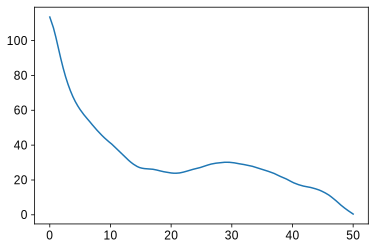

In [531]:
plt.figure()  # without line subtraction
Acorrcurve_baseav = np.average(Acorrcurve_base, axis=0)
plt.plot(dbcurve, Acorrcurve_baseav)

height = Acorrcurve_baseav[0] - np.min(Acorrcurve_baseav[60:140])  # select the min in the range of 12-28
bhwhm_base = db[npd.val_to_index([np.min(Acorrcurve_baseav[60:140]) + height/2], Acorrcurve_baseav)[0]]
print('Half width at half max: {:.2f} mT'.format(bhwhm_base))
tauphihwhm_base = 3*hbar/(2*1.602e-19*D*(bhwhm_base/1000))
print('tauphi: {:.3f} ps'.format(tauphihwhm_base*10**12))

300 mK

In [532]:
bhere = barr*1000 - 1.2
dbcurve = bhere - bhere[0]
dGn2_830_sub300 = dGn2_830_300 - dGn2_830_900 - dsigma_WAL(np.abs(bhere)/1000, **dfix, **dtau, tauphi=d['tauphi_2'])
Acorrcurve_300 = np.zeros(dGn2_830_sub300.shape)
Acorrder_300 = np.zeros(dGn2_830_sub300.shape)
bminarr_300 = np.zeros(dGn2_830_sub300.shape[0])
for i in range(dGn2_830_sub300.shape[0]):
    G = dGn2_830_sub300[i, :]
    
    ## uncomment if you want line subtraction (and make G above into G0). It happens to work well so far when not subtracting
#     sl, intc = np.polyfit(bhere, G0, 1)  # subtract a line
#     G = G0 - (bhere*sl + intc)

    acorr0 = correlate(G, G)
    acorr = acorr0[int(len(acorr0)/2):]
    Acorrcurve_300[i, :] = acorr
    
    der = np.gradient(gaussian_filter(acorr, 14))/np.gradient(dbcurve)
    Acorrder_300[i, :] = der
    
    bminarr_300[i] = dbcurve[np.argmin(der[:80])]

In [533]:
print(dbcurve[60], dbcurve[140])

11.999999999999998 28.0


21.22 is not a value in the array
Plotted 21.35 instead
Half width at half max: 3.67 mT
tauphi: 34.687 ps


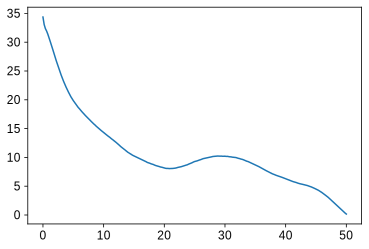

In [534]:
plt.figure()  # without line subtraction
Acorrcurve_300av = np.average(Acorrcurve_300, axis=0)
plt.plot(dbcurve, Acorrcurve_300av)

height = Acorrcurve_300av[0] - np.min(Acorrcurve_300av[60:140])  # select the min in the range of 12-28
bhwhm_300 = db[npd.val_to_index([np.min(Acorrcurve_300av[60:140]) + height/2], Acorrcurve_300av)[0]]
print('Half width at half max: {:.2f} mT'.format(bhwhm_300))
tauphihwhm_300 = 3*hbar/(2*1.602e-19*D*(bhwhm_300/1000))
print('tauphi: {:.3f} ps'.format(tauphihwhm_300*10**12))

500 mK

In [535]:
bhere = barr*1000 - 1.2
dbcurve = bhere - bhere[0]
dGn2_830_sub500 = dGn2_830_500 - dGn2_830_900 - dsigma_WAL(np.abs(bhere)/1000, **dfix, **dtau, tauphi=d['tauphi_3'])
Acorrcurve_500 = np.zeros(dGn2_830_sub500.shape)
Acorrder_500 = np.zeros(dGn2_830_sub500.shape)
bminarr_500 = np.zeros(dGn2_830_sub500.shape[0])
for i in range(dGn2_830_sub500.shape[0]):
    G = dGn2_830_sub500[i, :]
    
    ## uncomment if you want line subtraction (and make G above into G0). It happens to work well so far when not subtracting
#     sl, intc = np.polyfit(bhere, G0, 1)  # subtract a line
#     G = G0 - (bhere*sl + intc)

    acorr0 = correlate(G, G)
    acorr = acorr0[int(len(acorr0)/2):]
    Acorrcurve_500[i, :] = acorr
    
    der = np.gradient(gaussian_filter(acorr, 14))/np.gradient(dbcurve)
    Acorrder_500[i, :] = der
    
    bminarr_500[i] = dbcurve[np.argmin(der[:80])]

In [536]:
print(dbcurve[60], dbcurve[140])

11.999999999999998 28.0


6.68 is not a value in the array
Plotted 6.60 instead
Half width at half max: 2.98 mT
tauphi: 42.848 ps


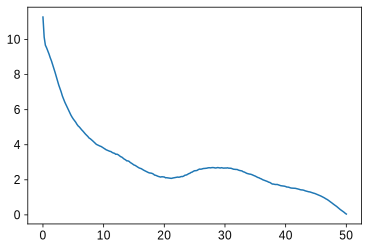

In [537]:
plt.figure()  # without line subtraction
Acorrcurve_500av = np.average(Acorrcurve_500, axis=0)
plt.plot(dbcurve, Acorrcurve_500av)

height = Acorrcurve_500av[0] - np.min(Acorrcurve_500av[60:140])  # select the min in the range of 12-28
bhwhm_500 = db[npd.val_to_index([np.min(Acorrcurve_500av[60:140]) + height/2], Acorrcurve_500av)[0]]
print('Half width at half max: {:.2f} mT'.format(bhwhm_500))
tauphihwhm_500 = 3*hbar/(2*1.602e-19*D*(bhwhm_500/1000))
print('tauphi: {:.3f} ps'.format(tauphihwhm_500*10**12))

700 mK

In [538]:
bhere = barr*1000 - 1.2
dbcurve = bhere - bhere[0]
dGn2_830_sub700 = dGn2_830_700 - dGn2_830_900 - dsigma_WAL(np.abs(bhere)/1000, **dfix, **dtau, tauphi=d['tauphi_4'])
Acorrcurve_700 = np.zeros(dGn2_830_sub700.shape)
Acorrder_700 = np.zeros(dGn2_830_sub700.shape)
bminarr_700 = np.zeros(dGn2_830_sub700.shape[0])
for i in range(dGn2_830_sub700.shape[0]):
    G = dGn2_830_sub700[i, :]
    
    ## uncomment if you want line subtraction (and make G above into G0). It happens to work well so far when not subtracting
#     sl, intc = np.polyfit(bhere, G0, 1)  # subtract a line
#     G = G0 - (bhere*sl + intc)

    acorr0 = correlate(G, G)
    acorr = acorr0[int(len(acorr0)/2):]
    Acorrcurve_700[i, :] = acorr
    
    der = np.gradient(gaussian_filter(acorr, 14))/np.gradient(dbcurve)
    Acorrder_700[i, :] = der
    
    bminarr_700[i] = dbcurve[np.argmin(der[:80])]

In [539]:
print(dbcurve[60], dbcurve[140])

11.999999999999998 28.0


6.68 is not a value in the array
Plotted 6.60 instead
Half width at half max: 2.98 mT
tauphi: 42.848 ps


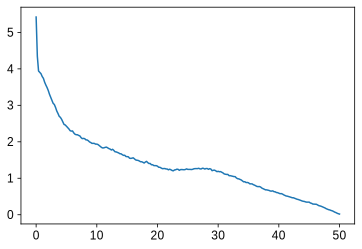

In [540]:
plt.figure()  # without line subtraction
Acorrcurve_700av = np.average(Acorrcurve_700, axis=0)
plt.plot(dbcurve, Acorrcurve_700av)

height = Acorrcurve_500av[0] - np.min(Acorrcurve_500av[60:140])  # select the min in the range of 12-28
bhwhm_500 = db[npd.val_to_index([np.min(Acorrcurve_500av[60:140]) + height/2], Acorrcurve_500av)[0]]
print('Half width at half max: {:.2f} mT'.format(bhwhm_500))
tauphihwhm_500 = 3*hbar/(2*1.602e-19*D*(bhwhm_500/1000))
print('tauphi: {:.3f} ps'.format(tauphihwhm_500*10**12))

These don't exactly match up to what I would have expected...